In [0]:
# For google colab only
# !git clone https://github.com/EliShayGH/cycle-gan-image2image-translation.git
# !cp ./cycle-gan-image2image-translation/helpers.py ./
# !cp -r ./cycle-gan-image2image-translation/samples_cyclegan ./
# !pip install pillow==6.1.0
# !pip3 install scipy==0.17.0

In [0]:
# Download data 

# !wget https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be66e78_summer2winter-yosemite/summer2winter-yosemite.zip
# !unzip -q summer2winter-yosemite.zip
# !rm summer2winter-yosemite.zip
# !mv ./summer2winter_yosemite ./summer2winter-yosemite

In [0]:
# loading in and transforming data
import os
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# visualizing data
import matplotlib.pyplot as plt
import numpy as np
import warnings

%matplotlib inline

### DataLoaders



In [0]:
def get_data_loader(image_type, image_dir='summer2winter-yosemite', 
                    image_size=128, batch_size=16, num_workers=0):
    """Returns training and test data loaders for a given image type, either 'summer' or 'winter'. 
       These images will be resized to 128x128x3, by default, converted into Tensors, and normalized.
    """
    
    # resize and normalize the images
    transform = transforms.Compose([transforms.Resize(image_size), # resize to 128x128
                                    transforms.ToTensor()])

    # get training and test directories
    image_path = './' + image_dir
    train_path = os.path.join(image_path, image_type)
    test_path = os.path.join(image_path, 'test_{}'.format(image_type))

    # define datasets using ImageFolder
    train_dataset = datasets.ImageFolder(train_path, transform)
    test_dataset = datasets.ImageFolder(test_path, transform)

    # create and return DataLoaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, test_loader

In [0]:
# Create train and test dataloaders for images from the two domains X and Y
# image_type = directory names for our data
dataloader_X, test_dataloader_X = get_data_loader(image_type='summer')
dataloader_Y, test_dataloader_Y = get_data_loader(image_type='winter')

In [0]:
# helper scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    
    # scale from 0-1 to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x



## Discriminators

The discriminators, $D_X$ and $D_Y$, in this CycleGAN are convolutional neural networks that see an image and attempt to classify it as real or fake. In this case, real is indicated by an output close to 1 and fake as close to 0. The discriminators have the following architecture:

<img src='https://github.com/EliShayGH/deep-learning-v2-pytorch/blob/master/cycle-gan/notebook_images/discriminator_layers.png?raw=1' width=80% />

This network sees a 128x128x3 image, and passes it through 5 convolutional layers that downsample the image by a factor of 2. The first four convolutional layers have a BatchNorm and ReLu activation function applied to their output, and the last acts as a classification layer that outputs one value.

### Convolutional Helper Function

To define the discriminators, you're expected to use the provided `conv` function, which creates a convolutional layer + an optional batch norm layer.

In [0]:
import torch.nn as nn
import torch.nn.functional as F

# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [0]:
class Discriminator(nn.Module):
    
    def __init__(self, conv_dim=64):
        super(Discriminator, self).__init__()

        # Define all convolutional layers
        # Should accept an RGB image as input and output a single value
        
        # 1st Conv layer has no batch_norm. dim = [64, 64, 64]
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False)
        # 2nd Conv layer. dim = [32, 32, 128]
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        # 3rd Conv layer. dim = [16, 16, 256]
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        # 4th Conv layer. dim = [8, 8, 512]
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4)
        # 5th Last Conv layer, Classification Layer has no batch_norm and stride is 1. dim = [1, 1, 1]
        self.conv5 = conv(conv_dim*8, 1, 4, stride=1, batch_norm=False)

    def forward(self, x):
        # feedforward behavior - relu to all but last layer
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.conv5(x)

        return x

## Generators

The generators, `G_XtoY` and `G_YtoX` (sometimes called F), are made of an **encoder**, a conv net that is responsible for turning an image into a smaller feature representation, and a **decoder**, a *transpose_conv* net that is responsible for turning that representation into an transformed image. These generators, one from XtoY and one from YtoX, have the following architecture:

<img src='https://github.com/EliShayGH/deep-learning-v2-pytorch/blob/master/cycle-gan/notebook_images/cyclegan_generator_ex.png?raw=1' width=90% />

This network sees a 128x128x3 image, compresses it into a feature representation as it goes through three convolutional layers and reaches a series of residual blocks. It goes through a few (typically 6 or more) of these residual blocks, then it goes through three transpose convolutional layers (sometimes called *de-conv* layers) which upsample the output of the resnet blocks and create a new image!

Note that most of the convolutional and transpose-convolutional layers have BatchNorm and ReLu functions applied to their outputs with the exception of the final transpose convolutional layer, which has a `tanh` activation function applied to the output. Also, the residual blocks are made of convolutional and batch normalization layers, which we'll go over in more detail, next.

---
### Residual Block Class

To define the generators, you're expected to define a `ResidualBlock` class which will help you connect the encoder and decoder portions of the generators. You might be wondering, what exactly is a Resnet block? It may sound familiar from something like ResNet50 for image classification, pictured below.

<img src='https://github.com/EliShayGH/deep-learning-v2-pytorch/blob/master/cycle-gan/notebook_images/resnet_50.png?raw=1' width=90%/>

ResNet blocks rely on connecting the output of one layer with the input of an earlier layer. The motivation for this structure is as follows: very deep neural networks can be difficult to train. Deeper networks are more likely to have vanishing or exploding gradients and, therefore, have trouble reaching convergence; batch normalization helps with this a bit. However, during training, we often see that deep networks respond with a kind of training degradation. Essentially, the training accuracy stops improving and gets saturated at some point during training. In the worst cases, deep models would see their training accuracy actually worsen over time!

One solution to this problem is to use **Resnet blocks** that allow us to learn so-called *residual functions* as they are applied to layer inputs. You can read more about this proposed architecture in the paper, [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf) by Kaiming He et. al, and the below image is from that paper.

<img src='https://github.com/EliShayGH/deep-learning-v2-pytorch/blob/master/cycle-gan/notebook_images/resnet_block.png?raw=1' width=40%/>

### Residual Functions

Usually, when we create a deep learning model, the model (several layers with activations applied) is responsible for learning a mapping, `M`, from an input `x` to an output `y`.
>`M(x) = y` (Equation 1)

Instead of learning a direct mapping from `x` to `y`, we can instead define a **residual function**
> `F(x) = M(x) - x`

This looks at the difference between a mapping applied to x and the original input, x. `F(x)` is, typically, two convolutional layers + normalization layer and a ReLu in between. These convolutional layers should have the same number of inputs as outputs. This mapping can then be written as the following; a function of the residual function and the input x. The addition step creates a kind of loop that connects the input x to the output, y:
>`M(x) = F(x) + x` (Equation 2) or

>`y = F(x) + x` (Equation 3)

#### Optimizing a Residual Function

The idea is that it is easier to optimize this residual function `F(x)` than it is to optimize the original mapping `M(x)`. Consider an example; what if we want `y = x`?

From our first, direct mapping equation, **Equation 1**, we could set `M(x) = x` but it is easier to solve the residual equation `F(x) = 0`, which, when plugged in to **Equation 3**, yields `y = x`.


### Defining the `ResidualBlock` Class

To define the `ResidualBlock` class, we'll define residual functions (a series of layers), apply them to an input x and add them to that same input. This is defined just like any other neural network, with an `__init__` function and the addition step in the `forward` function. 

In our case, you'll want to define the residual block as:
* Two convolutional layers with the same size input and output
* Batch normalization applied to the outputs of the convolutional layers
* A ReLu function on the output of the *first* convolutional layer

Then, in the `forward` function, add the input x to this residual block. Feel free to use the helper `conv` function from above to create this block.

In [0]:
# residual block class
class ResidualBlock(nn.Module):
    """Defines a residual block.
       This adds an input x to a convolutional layer (applied to x) with the same size input and output.
       These blocks allow a model to learn an effective transformation from one domain to another.
    """
    def __init__(self, conv_dim):
        super(ResidualBlock, self).__init__()
        # conv_dim = number of inputs  
        
        # define two convolutional layers + batch normalization that will act as our residual function, F(x)
        # layers should have the same shape input as output; I suggest a kernel_size of 3
        self.conv1 = conv(conv_dim, conv_dim, 3, 1, batch_norm=True)
        self.conv2 = conv(conv_dim, conv_dim, 3, 1, batch_norm=True)
        
    def forward(self, x):
        # apply a ReLu activation the outputs of the first layer
        # return a summed output, x + resnet_block(x)
        output = F.relu(self.conv1(x))
        output = x + self.conv2(output)
        
        return output
    

### Transpose Convolutional Helper Function

To define the generators, you're expected to use the above `conv` function, `ResidualBlock` class, and the below `deconv` helper function, which creates a transpose convolutional layer + an optional batchnorm layer.

In [0]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transpose convolutional layer, with optional batch normalization.
    """
    layers = []
    # append transpose conv layer
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    # optional batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [0]:
class CycleGenerator(nn.Module):
    
    def __init__(self, conv_dim=64, n_res_blocks=6):
        super(CycleGenerator, self).__init__()

        # 1. Define the encoder part of the generator
        self.conv1 = conv(3, conv_dim, 4)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)

        # 2. Define the resnet part of the generator
        res_layers = []
        for layer in range(n_res_blocks):
          res_layers.append(ResidualBlock(conv_dim*4))

        self.resblocks = nn.Sequential(*res_layers)

        # 3. Define the decoder part of the generator
        self.deconv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.deconv2 = deconv(conv_dim*2, conv_dim, 4)
        self.deconv3 = deconv(conv_dim, 3, 4, batch_norm=False)

    def forward(self, x):
        """Given an image x, returns a transformed image."""
        # define feedforward behavior, applying activations as necessary
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        x = self.resblocks.forward(x)

        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.tanh(self.deconv3(x))

        return x

In [0]:
def create_model(g_conv_dim=64, d_conv_dim=64, n_res_blocks=6):
    """Builds the generators and discriminators."""
    
    # Instantiate generators
    G_XtoY = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
    G_YtoX = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
    # Instantiate discriminators
    D_X = Discriminator(conv_dim=d_conv_dim)
    D_Y = Discriminator(conv_dim=d_conv_dim)

    # move models to GPU, if available
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        G_XtoY.to(device)
        G_YtoX.to(device)
        D_X.to(device)
        D_Y.to(device)
        print('Models moved to GPU.')
    else:
        print('Only CPU available.')

    return G_XtoY, G_YtoX, D_X, D_Y

In [13]:
# call the function to get models
G_XtoY, G_YtoX, D_X, D_Y = create_model()

Models moved to GPU.


## Discriminator and Generator Losses

Computing the discriminator and the generator losses are key to getting a CycleGAN to train.

<img src='https://github.com/EliShayGH/deep-learning-v2-pytorch/blob/master/cycle-gan/notebook_images/CycleGAN_loss.png?raw=1' width=50% height=10% />

**Image from [original paper](https://arxiv.org/abs/1703.10593) by Jun-Yan Zhu et. al.**

* The CycleGAN contains two mapping functions $G: X \rightarrow Y$ and $F: Y \rightarrow X$, and associated adversarial discriminators $D_Y$ and $D_X$. **(a)** $D_Y$ encourages $G$ to translate $X$ into outputs indistinguishable from domain $Y$, and vice versa for $D_X$ and $F$.

* To further regularize the mappings, we introduce two cycle consistency losses that capture the intuition that if
we translate from one domain to the other and back again we should arrive at where we started. **(b)** Forward cycle-consistency loss and **(c)** backward cycle-consistency loss.

## Least Squares GANs

We've seen that regular GANs treat the discriminator as a classifier with the sigmoid cross entropy loss function. However, this loss function may lead to the vanishing gradients problem during the learning process. To overcome such a problem, we'll use a least squares loss function for the discriminator. This structure is also referred to as a least squares GAN or LSGAN, and you can [read the original paper on LSGANs, here](https://arxiv.org/pdf/1611.04076.pdf). The authors show that LSGANs are able to generate higher quality images than regular GANs and that this loss type is a bit more stable during training! 

### Discriminator Losses

The discriminator losses will be mean squared errors between the output of the discriminator, given an image, and the target value, 0 or 1, depending on whether it should classify that image as fake or real. For example, for a *real* image, `x`, we can train $D_X$ by looking at how close it is to recognizing and image `x` as real using the mean squared error:

```
out_x = D_X(x)
real_err = torch.mean((out_x-1)**2)
```

### Generator Losses

Calculating the generator losses will look somewhat similar to calculating the discriminator loss; there will still be steps in which you generate fake images that look like they belong to the set of $X$ images but are based on real images in set $Y$, and vice versa. You'll compute the "real loss" on those generated images by looking at the output of the discriminator as it's applied to these _fake_ images; this time, your generator aims to make the discriminator classify these fake images as *real* images. 

#### Cycle Consistency Loss

In addition to the adversarial losses, the generator loss terms will also include the **cycle consistency loss**. This loss is a measure of how good a reconstructed image is, when compared to an original image. 

Say you have a fake, generated image, `x_hat`, and a real image, `y`. You can get a reconstructed `y_hat` by applying `G_XtoY(x_hat) = y_hat` and then check to see if this reconstruction `y_hat` and the orginal image `y` match. For this, we recommed calculating the L1 loss, which is an absolute difference, between reconstructed and real images. You may also choose to multiply this loss by some weight value `lambda_weight` to convey its importance.

<img src='https://github.com/EliShayGH/deep-learning-v2-pytorch/blob/master/cycle-gan/notebook_images/reconstruction_error.png?raw=1' width=50% height=10% />

The total generator loss will be the sum of the generator losses and the forward and backward cycle consistency losses.

In [0]:
def real_mse_loss(D_out):
    # how close is the produced output from being "real"?
    return torch.mean((D_out-1)**2)

def fake_mse_loss(D_out):
    # how close is the produced output from being "fake"?
    return torch.mean((D_out-0)**2)

def cycle_consistency_loss(real_im, reconstructed_im, lambda_weight):
    # calculate reconstruction loss 
    reconstr_loss = torch.mean(torch.abs(real_im - reconstructed_im))
    # return weighted loss
    return lambda_weight*reconstr_loss

### Define the Optimizers

Next, let's define how this model will update its weights. This, like the GANs you may have seen before, uses [Adam](https://pytorch.org/docs/stable/optim.html#algorithms) optimizers for the discriminator and generator. It's again recommended that you take a [look at the original, CycleGAN paper](https://arxiv.org/pdf/1703.10593.pdf) to get starting hyperparameter values.


In [0]:
import torch.optim as optim

# hyperparams for Adam optimizers
lr=0.0002
beta1=0.5
beta2=0.999

g_params = list(G_XtoY.parameters()) + list(G_YtoX.parameters())  # Get generator parameters

# Create optimizers for the generators and discriminators
g_optimizer = optim.Adam(g_params, lr, [beta1, beta2])
d_x_optimizer = optim.Adam(D_X.parameters(), lr, [beta1, beta2])
d_y_optimizer = optim.Adam(D_Y.parameters(), lr, [beta1, beta2])

---

## Training a CycleGAN

When a CycleGAN trains, and sees one batch of real images from set $X$ and $Y$, it trains by performing the following steps:

**Training the Discriminators**
1. Compute the discriminator $D_X$ loss on real images
2. Generate fake images that look like domain $X$ based on real images in domain $Y$
3. Compute the fake loss for $D_X$
4. Compute the total loss and perform backpropagation and $D_X$ optimization
5. Repeat steps 1-4 only with $D_Y$ and your domains switched!


**Training the Generators**
1. Generate fake images that look like domain $X$ based on real images in domain $Y$
2. Compute the generator loss based on how $D_X$ responds to fake $X$
3. Generate *reconstructed* $\hat{Y}$ images based on the fake $X$ images generated in step 1
4. Compute the cycle consistency loss by comparing the reconstructions with real $Y$ images
5. Repeat steps 1-4 only swapping domains
6. Add up all the generator and reconstruction losses and perform backpropagation + optimization

<img src='https://github.com/EliShayGH/deep-learning-v2-pytorch/blob/master/cycle-gan/notebook_images/cycle_consistency_ex.png?raw=1' width=70% />


### Saving Your Progress

A CycleGAN repeats its training process, alternating between training the discriminators and the generators, for a specified number of training iterations. You've been given code that will save some example generated images that the CycleGAN has learned to generate after a certain number of training iterations. Along with looking at the losses, these example generations should give you an idea of how well your network has trained.

Below, you may choose to keep all default parameters; your only task is to calculate the appropriate losses and complete the training cycle.

In [0]:
# import save code
from helpers import save_samples, checkpoint

In [0]:
# train the network
def training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, 
                  n_epochs=1000):
    
    print_every=10
    
    # keep track of losses over time
    losses = []

    test_iter_X = iter(test_dataloader_X)
    test_iter_Y = iter(test_dataloader_Y)

    # Get some fixed data from domains X and Y for sampling. These are images that are held
    # constant throughout training, that allow us to inspect the model's performance.
    fixed_X = test_iter_X.next()[0]
    fixed_Y = test_iter_Y.next()[0]
    fixed_X = scale(fixed_X) # make sure to scale to a range -1 to 1
    fixed_Y = scale(fixed_Y)

    # batches per epoch
    iter_X = iter(dataloader_X)
    iter_Y = iter(dataloader_Y)
    batches_per_epoch = min(len(iter_X), len(iter_Y))

    for epoch in range(1, n_epochs+1):

        # Reset iterators for each epoch
        if epoch % batches_per_epoch == 0:
            iter_X = iter(dataloader_X)
            iter_Y = iter(dataloader_Y)

        images_X, _ = iter_X.next()
        images_X = scale(images_X) # make sure to scale to a range -1 to 1

        images_Y, _ = iter_Y.next()
        images_Y = scale(images_Y)
        
        # move images to GPU if available (otherwise stay on CPU)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        images_X = images_X.to(device)
        images_Y = images_Y.to(device)


        # ============================================
        #            TRAIN THE DISCRIMINATORS
        # ============================================

        ##   First: D_X, real and fake loss components   ##
        d_x_optimizer.zero_grad()
        # 1. Compute the discriminator losses on real images
        out_x = D_X(images_X)
        D_X_real_loss = real_mse_loss(out_x)

        # 2. Generate fake images that look like domain X based on real images in domain Y
        fake_x = G_YtoX(images_Y)

        # 3. Compute the fake loss for D_X
        out_x = D_X(fake_x)
        D_X_fake_loss = fake_mse_loss(out_x)

        # 4. Compute the total loss and perform backprop
        d_x_loss = D_X_real_loss + D_X_fake_loss
        d_x_loss.backward(retain_graph=True)
        d_x_optimizer.step()
        
        ##   Second: D_Y, real and fake loss components   ##
        d_y_optimizer.zero_grad()

        # 1. Compute the discriminator losses on real images
        out_y = D_Y(images_Y)
        D_Y_real_loss = real_mse_loss(out_y)

        # 2. Generate fake images that look like domain Y based on real images in domain X
        fake_y = G_XtoY(images_X)

        # 3. Compute the fake loss for D_Y
        out_y = D_Y(fake_y)
        D_Y_fake_loss = fake_mse_loss(out_y)

        # 4. Compute the total loss and perform backprop
        d_y_loss = D_Y_real_loss + D_Y_fake_loss
        d_y_loss.backward(retain_graph=True)
        d_y_optimizer.step()
        

        # =========================================
        #            TRAIN THE GENERATORS
        # =========================================

        ##    First: generate fake X images and reconstructed Y images    ##
        g_optimizer.zero_grad()
        
        # 1. Generate fake images that look like domain X based on real images in domain Y
        fake_X = G_YtoX(images_Y)

        # 2. Compute the generator loss based on domain X
        out_x = D_X(fake_X)
        g_YtoX_loss = real_mse_loss(out_x)

        # 3. Create a reconstructed y
        reconstructed_Y = G_XtoY(fake_X)

        # 4. Compute the cycle consistency loss (the reconstruction loss)
        reconstructed_y_loss = cycle_consistency_loss(images_Y, reconstructed_Y, lambda_weight=10)

        ##    Second: generate fake Y images and reconstructed X images    ##
         
        # 1. Generate fake images that look like domain X based on real images in domain Y
        fake_Y = G_XtoY(images_X)

        # 2. Compute the generator loss based on domain X
        out_x = D_Y(fake_Y)
        g_XtoY_loss = real_mse_loss(out_y)

        # 3. Create a reconstructed y
        reconstructed_X = G_YtoX(fake_Y)

        # 4. Compute the cycle consistency loss (the reconstruction loss)
        reconstructed_x_loss = cycle_consistency_loss(images_X, reconstructed_X, lambda_weight=10)


        # 5. Add up all generator and reconstructed losses and perform backprop
        g_total_loss = g_YtoX_loss + g_XtoY_loss + reconstructed_y_loss + reconstructed_x_loss
      
        g_total_loss.backward(retain_graph=True)
        g_optimizer.step()
        
        # Print the log info
        if epoch % print_every == 0:
            # append real and fake discriminator losses and the generator loss
            losses.append((d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))
            print('Epoch [{:5d}/{:5d}] | d_X_loss: {:6.4f} | d_Y_loss: {:6.4f} | g_total_loss: {:6.4f}'.format(
                    epoch, n_epochs, d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))

            
        sample_every=100
        # Save the generated samples
        if epoch % sample_every == 0:
            G_YtoX.eval() # set generators to eval mode for sample generation
            G_XtoY.eval()
            save_samples(epoch, fixed_Y, fixed_X, G_YtoX, G_XtoY, batch_size=16)
            G_YtoX.train()
            G_XtoY.train()

        # uncomment these lines, if you want to save your model
#         checkpoint_every=1000
#         # Save the model parameters
#         if epoch % checkpoint_every == 0:
#             checkpoint(epoch, G_XtoY, G_YtoX, D_X, D_Y)

    return losses


In [18]:
n_epochs = 5000 # keep this small when testing if a model first works, then increase it to >=1000

losses = training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, n_epochs=n_epochs)

Epoch [   10/ 5000] | d_X_loss: 0.3204 | d_Y_loss: 0.9210 | g_total_loss: 9.3250
Epoch [   20/ 5000] | d_X_loss: 0.2849 | d_Y_loss: 0.3531 | g_total_loss: 7.4824
Epoch [   30/ 5000] | d_X_loss: 0.4102 | d_Y_loss: 0.6082 | g_total_loss: 6.0919
Epoch [   40/ 5000] | d_X_loss: 0.3256 | d_Y_loss: 0.2868 | g_total_loss: 5.3801
Epoch [   50/ 5000] | d_X_loss: 0.3522 | d_Y_loss: 0.5951 | g_total_loss: 5.9100
Epoch [   60/ 5000] | d_X_loss: 0.4780 | d_Y_loss: 0.9046 | g_total_loss: 5.5371
Epoch [   70/ 5000] | d_X_loss: 0.4266 | d_Y_loss: 0.5394 | g_total_loss: 6.2889
Epoch [   80/ 5000] | d_X_loss: 0.5164 | d_Y_loss: 0.3470 | g_total_loss: 4.8871
Epoch [   90/ 5000] | d_X_loss: 0.5344 | d_Y_loss: 0.4179 | g_total_loss: 5.2765


Epoch [  100/ 5000] | d_X_loss: 0.4423 | d_Y_loss: 0.4544 | g_total_loss: 4.7640


Saved samples_cyclegan/sample-000100-X-Y.png
Saved samples_cyclegan/sample-000100-Y-X.png
Epoch [  110/ 5000] | d_X_loss: 0.5854 | d_Y_loss: 0.4314 | g_total_loss: 4.0249
Epoch [  120/ 5000] | d_X_loss: 0.3992 | d_Y_loss: 0.6300 | g_total_loss: 5.4485
Epoch [  130/ 5000] | d_X_loss: 0.5583 | d_Y_loss: 0.3338 | g_total_loss: 3.9666
Epoch [  140/ 5000] | d_X_loss: 0.3706 | d_Y_loss: 0.5025 | g_total_loss: 4.3688
Epoch [  150/ 5000] | d_X_loss: 0.3547 | d_Y_loss: 0.1936 | g_total_loss: 4.2517
Epoch [  160/ 5000] | d_X_loss: 0.5027 | d_Y_loss: 0.5894 | g_total_loss: 5.0801
Epoch [  170/ 5000] | d_X_loss: 0.3418 | d_Y_loss: 0.2637 | g_total_loss: 5.1967
Epoch [  180/ 5000] | d_X_loss: 0.5557 | d_Y_loss: 0.5077 | g_total_loss: 4.3061
Epoch [  190/ 5000] | d_X_loss: 0.4462 | d_Y_loss: 0.4457 | g_total_loss: 4.6896


Epoch [  200/ 5000] | d_X_loss: 0.4775 | d_Y_loss: 0.4608 | g_total_loss: 4.2943


Saved samples_cyclegan/sample-000200-X-Y.png
Saved samples_cyclegan/sample-000200-Y-X.png
Epoch [  210/ 5000] | d_X_loss: 0.4403 | d_Y_loss: 0.2832 | g_total_loss: 4.5727
Epoch [  220/ 5000] | d_X_loss: 0.3936 | d_Y_loss: 0.4134 | g_total_loss: 4.0038
Epoch [  230/ 5000] | d_X_loss: 0.2927 | d_Y_loss: 0.5391 | g_total_loss: 4.2651
Epoch [  240/ 5000] | d_X_loss: 0.4390 | d_Y_loss: 0.4628 | g_total_loss: 4.5300
Epoch [  250/ 5000] | d_X_loss: 0.2495 | d_Y_loss: 0.4168 | g_total_loss: 5.2784
Epoch [  260/ 5000] | d_X_loss: 0.3912 | d_Y_loss: 0.2696 | g_total_loss: 4.4396
Epoch [  270/ 5000] | d_X_loss: 0.3844 | d_Y_loss: 0.3767 | g_total_loss: 4.1348
Epoch [  280/ 5000] | d_X_loss: 0.4809 | d_Y_loss: 0.4166 | g_total_loss: 4.4537
Epoch [  290/ 5000] | d_X_loss: 0.4655 | d_Y_loss: 0.4393 | g_total_loss: 4.3897


Epoch [  300/ 5000] | d_X_loss: 0.5785 | d_Y_loss: 0.3237 | g_total_loss: 4.7641


Saved samples_cyclegan/sample-000300-X-Y.png
Saved samples_cyclegan/sample-000300-Y-X.png
Epoch [  310/ 5000] | d_X_loss: 0.4665 | d_Y_loss: 0.5936 | g_total_loss: 4.1227
Epoch [  320/ 5000] | d_X_loss: 0.3733 | d_Y_loss: 0.2752 | g_total_loss: 4.4918
Epoch [  330/ 5000] | d_X_loss: 1.1193 | d_Y_loss: 0.9089 | g_total_loss: 3.3691
Epoch [  340/ 5000] | d_X_loss: 0.3930 | d_Y_loss: 0.2774 | g_total_loss: 4.6027
Epoch [  350/ 5000] | d_X_loss: 0.4427 | d_Y_loss: 0.4296 | g_total_loss: 4.6679
Epoch [  360/ 5000] | d_X_loss: 0.1665 | d_Y_loss: 0.4134 | g_total_loss: 4.2093
Epoch [  370/ 5000] | d_X_loss: 0.3256 | d_Y_loss: 0.5785 | g_total_loss: 4.2298
Epoch [  380/ 5000] | d_X_loss: 1.0242 | d_Y_loss: 0.3526 | g_total_loss: 4.8764
Epoch [  390/ 5000] | d_X_loss: 0.4030 | d_Y_loss: 0.5386 | g_total_loss: 5.2472


Epoch [  400/ 5000] | d_X_loss: 0.3395 | d_Y_loss: 0.4907 | g_total_loss: 3.6979


Saved samples_cyclegan/sample-000400-X-Y.png
Saved samples_cyclegan/sample-000400-Y-X.png
Epoch [  410/ 5000] | d_X_loss: 0.4884 | d_Y_loss: 0.4854 | g_total_loss: 3.8483
Epoch [  420/ 5000] | d_X_loss: 0.3653 | d_Y_loss: 0.6079 | g_total_loss: 4.6539
Epoch [  430/ 5000] | d_X_loss: 1.0495 | d_Y_loss: 0.2561 | g_total_loss: 3.8863
Epoch [  440/ 5000] | d_X_loss: 0.3444 | d_Y_loss: 0.4070 | g_total_loss: 3.3589
Epoch [  450/ 5000] | d_X_loss: 0.5212 | d_Y_loss: 0.2701 | g_total_loss: 4.1961
Epoch [  460/ 5000] | d_X_loss: 0.3394 | d_Y_loss: 0.3903 | g_total_loss: 3.4260
Epoch [  470/ 5000] | d_X_loss: 0.3742 | d_Y_loss: 0.4388 | g_total_loss: 3.7961
Epoch [  480/ 5000] | d_X_loss: 0.4519 | d_Y_loss: 0.3936 | g_total_loss: 3.9655
Epoch [  490/ 5000] | d_X_loss: 0.7256 | d_Y_loss: 0.4936 | g_total_loss: 3.8979


Epoch [  500/ 5000] | d_X_loss: 0.4127 | d_Y_loss: 0.4496 | g_total_loss: 3.3165


Saved samples_cyclegan/sample-000500-X-Y.png
Saved samples_cyclegan/sample-000500-Y-X.png
Epoch [  510/ 5000] | d_X_loss: 0.3287 | d_Y_loss: 0.3709 | g_total_loss: 4.7719
Epoch [  520/ 5000] | d_X_loss: 0.2875 | d_Y_loss: 0.4056 | g_total_loss: 3.9416
Epoch [  530/ 5000] | d_X_loss: 0.4516 | d_Y_loss: 0.5878 | g_total_loss: 3.5088
Epoch [  540/ 5000] | d_X_loss: 0.3626 | d_Y_loss: 0.4277 | g_total_loss: 4.0756
Epoch [  550/ 5000] | d_X_loss: 0.6266 | d_Y_loss: 0.3700 | g_total_loss: 4.4772
Epoch [  560/ 5000] | d_X_loss: 0.3596 | d_Y_loss: 0.3874 | g_total_loss: 3.7880
Epoch [  570/ 5000] | d_X_loss: 0.4866 | d_Y_loss: 0.4412 | g_total_loss: 3.7969
Epoch [  580/ 5000] | d_X_loss: 0.4043 | d_Y_loss: 0.4581 | g_total_loss: 3.5208
Epoch [  590/ 5000] | d_X_loss: 0.3578 | d_Y_loss: 0.3416 | g_total_loss: 4.2186


Epoch [  600/ 5000] | d_X_loss: 0.5652 | d_Y_loss: 0.3739 | g_total_loss: 3.7875


Saved samples_cyclegan/sample-000600-X-Y.png
Saved samples_cyclegan/sample-000600-Y-X.png
Epoch [  610/ 5000] | d_X_loss: 0.3231 | d_Y_loss: 0.3373 | g_total_loss: 3.9614
Epoch [  620/ 5000] | d_X_loss: 0.4177 | d_Y_loss: 0.8930 | g_total_loss: 5.2446
Epoch [  630/ 5000] | d_X_loss: 0.2725 | d_Y_loss: 0.2867 | g_total_loss: 3.9492
Epoch [  640/ 5000] | d_X_loss: 0.4615 | d_Y_loss: 0.4093 | g_total_loss: 3.5964
Epoch [  650/ 5000] | d_X_loss: 0.3227 | d_Y_loss: 0.5850 | g_total_loss: 3.4988
Epoch [  660/ 5000] | d_X_loss: 0.3658 | d_Y_loss: 0.7611 | g_total_loss: 4.2541
Epoch [  670/ 5000] | d_X_loss: 0.2826 | d_Y_loss: 0.6184 | g_total_loss: 4.1593
Epoch [  680/ 5000] | d_X_loss: 0.2939 | d_Y_loss: 0.6488 | g_total_loss: 3.3658
Epoch [  690/ 5000] | d_X_loss: 0.3840 | d_Y_loss: 0.4018 | g_total_loss: 3.5817


Epoch [  700/ 5000] | d_X_loss: 0.3555 | d_Y_loss: 0.4430 | g_total_loss: 3.8338


Saved samples_cyclegan/sample-000700-X-Y.png
Saved samples_cyclegan/sample-000700-Y-X.png
Epoch [  710/ 5000] | d_X_loss: 0.4271 | d_Y_loss: 0.3214 | g_total_loss: 3.5806
Epoch [  720/ 5000] | d_X_loss: 0.4504 | d_Y_loss: 0.4085 | g_total_loss: 3.7462
Epoch [  730/ 5000] | d_X_loss: 0.4294 | d_Y_loss: 0.4708 | g_total_loss: 3.4855
Epoch [  740/ 5000] | d_X_loss: 0.4674 | d_Y_loss: 0.5704 | g_total_loss: 3.8633
Epoch [  750/ 5000] | d_X_loss: 0.3990 | d_Y_loss: 0.3560 | g_total_loss: 4.3479
Epoch [  760/ 5000] | d_X_loss: 0.3942 | d_Y_loss: 0.3460 | g_total_loss: 3.9566
Epoch [  770/ 5000] | d_X_loss: 0.2266 | d_Y_loss: 0.5125 | g_total_loss: 4.3281
Epoch [  780/ 5000] | d_X_loss: 0.2172 | d_Y_loss: 0.2368 | g_total_loss: 4.4672
Epoch [  790/ 5000] | d_X_loss: 0.2796 | d_Y_loss: 0.3545 | g_total_loss: 3.8173


Epoch [  800/ 5000] | d_X_loss: 0.2790 | d_Y_loss: 0.1967 | g_total_loss: 3.8470


Saved samples_cyclegan/sample-000800-X-Y.png
Saved samples_cyclegan/sample-000800-Y-X.png
Epoch [  810/ 5000] | d_X_loss: 0.5651 | d_Y_loss: 0.5984 | g_total_loss: 3.0049
Epoch [  820/ 5000] | d_X_loss: 0.5628 | d_Y_loss: 0.3266 | g_total_loss: 3.4423
Epoch [  830/ 5000] | d_X_loss: 0.3219 | d_Y_loss: 0.6787 | g_total_loss: 3.1997
Epoch [  840/ 5000] | d_X_loss: 0.3457 | d_Y_loss: 0.3253 | g_total_loss: 4.0366
Epoch [  850/ 5000] | d_X_loss: 0.4840 | d_Y_loss: 0.4416 | g_total_loss: 5.1157
Epoch [  860/ 5000] | d_X_loss: 0.3678 | d_Y_loss: 0.5127 | g_total_loss: 3.5594
Epoch [  870/ 5000] | d_X_loss: 0.2500 | d_Y_loss: 0.1900 | g_total_loss: 3.8938
Epoch [  880/ 5000] | d_X_loss: 0.2429 | d_Y_loss: 0.2771 | g_total_loss: 4.5071
Epoch [  890/ 5000] | d_X_loss: 0.5740 | d_Y_loss: 0.4832 | g_total_loss: 3.6686


Epoch [  900/ 5000] | d_X_loss: 0.3987 | d_Y_loss: 0.3392 | g_total_loss: 4.0255


Saved samples_cyclegan/sample-000900-X-Y.png
Saved samples_cyclegan/sample-000900-Y-X.png
Epoch [  910/ 5000] | d_X_loss: 0.4055 | d_Y_loss: 0.3560 | g_total_loss: 3.7487
Epoch [  920/ 5000] | d_X_loss: 0.4277 | d_Y_loss: 0.4221 | g_total_loss: 3.3080
Epoch [  930/ 5000] | d_X_loss: 0.3159 | d_Y_loss: 0.3153 | g_total_loss: 3.5111
Epoch [  940/ 5000] | d_X_loss: 0.3745 | d_Y_loss: 0.3550 | g_total_loss: 3.6291
Epoch [  950/ 5000] | d_X_loss: 0.3088 | d_Y_loss: 0.4320 | g_total_loss: 4.3598
Epoch [  960/ 5000] | d_X_loss: 0.4540 | d_Y_loss: 0.3848 | g_total_loss: 3.9015
Epoch [  970/ 5000] | d_X_loss: 0.3737 | d_Y_loss: 0.2839 | g_total_loss: 3.2951
Epoch [  980/ 5000] | d_X_loss: 0.2942 | d_Y_loss: 0.4553 | g_total_loss: 3.4698
Epoch [  990/ 5000] | d_X_loss: 0.4009 | d_Y_loss: 0.4078 | g_total_loss: 3.2268


Epoch [ 1000/ 5000] | d_X_loss: 0.5393 | d_Y_loss: 0.3691 | g_total_loss: 3.3500


Saved samples_cyclegan/sample-001000-X-Y.png
Saved samples_cyclegan/sample-001000-Y-X.png
Epoch [ 1010/ 5000] | d_X_loss: 0.3360 | d_Y_loss: 0.3042 | g_total_loss: 3.7957
Epoch [ 1020/ 5000] | d_X_loss: 0.3067 | d_Y_loss: 0.2706 | g_total_loss: 3.9671
Epoch [ 1030/ 5000] | d_X_loss: 0.6166 | d_Y_loss: 0.4266 | g_total_loss: 4.1852
Epoch [ 1040/ 5000] | d_X_loss: 0.4576 | d_Y_loss: 0.8504 | g_total_loss: 6.2806
Epoch [ 1050/ 5000] | d_X_loss: 0.3020 | d_Y_loss: 0.3457 | g_total_loss: 3.7448
Epoch [ 1060/ 5000] | d_X_loss: 0.3561 | d_Y_loss: 0.4035 | g_total_loss: 3.6419
Epoch [ 1070/ 5000] | d_X_loss: 0.2097 | d_Y_loss: 0.4995 | g_total_loss: 3.6135
Epoch [ 1080/ 5000] | d_X_loss: 0.4644 | d_Y_loss: 0.2226 | g_total_loss: 3.9107
Epoch [ 1090/ 5000] | d_X_loss: 0.2225 | d_Y_loss: 0.2701 | g_total_loss: 3.8535


Epoch [ 1100/ 5000] | d_X_loss: 0.4211 | d_Y_loss: 0.4674 | g_total_loss: 3.1858


Saved samples_cyclegan/sample-001100-X-Y.png
Saved samples_cyclegan/sample-001100-Y-X.png
Epoch [ 1110/ 5000] | d_X_loss: 0.3100 | d_Y_loss: 0.4225 | g_total_loss: 4.4943
Epoch [ 1120/ 5000] | d_X_loss: 0.3635 | d_Y_loss: 0.3758 | g_total_loss: 3.7742
Epoch [ 1130/ 5000] | d_X_loss: 0.6582 | d_Y_loss: 0.2890 | g_total_loss: 3.5913
Epoch [ 1140/ 5000] | d_X_loss: 0.2873 | d_Y_loss: 0.7943 | g_total_loss: 3.9466
Epoch [ 1150/ 5000] | d_X_loss: 0.5989 | d_Y_loss: 0.3269 | g_total_loss: 2.9126
Epoch [ 1160/ 5000] | d_X_loss: 0.2484 | d_Y_loss: 0.3934 | g_total_loss: 4.4498
Epoch [ 1170/ 5000] | d_X_loss: 0.2661 | d_Y_loss: 0.2869 | g_total_loss: 3.9652
Epoch [ 1180/ 5000] | d_X_loss: 0.2226 | d_Y_loss: 0.4061 | g_total_loss: 4.3081
Epoch [ 1190/ 5000] | d_X_loss: 0.3338 | d_Y_loss: 0.4165 | g_total_loss: 4.2861


Epoch [ 1200/ 5000] | d_X_loss: 0.3501 | d_Y_loss: 0.3868 | g_total_loss: 3.3963


Saved samples_cyclegan/sample-001200-X-Y.png
Saved samples_cyclegan/sample-001200-Y-X.png
Epoch [ 1210/ 5000] | d_X_loss: 0.2623 | d_Y_loss: 0.3571 | g_total_loss: 3.6938
Epoch [ 1220/ 5000] | d_X_loss: 0.4852 | d_Y_loss: 0.3628 | g_total_loss: 6.0082
Epoch [ 1230/ 5000] | d_X_loss: 0.4026 | d_Y_loss: 0.2660 | g_total_loss: 3.7582
Epoch [ 1240/ 5000] | d_X_loss: 0.2716 | d_Y_loss: 0.3825 | g_total_loss: 3.5857
Epoch [ 1250/ 5000] | d_X_loss: 0.5775 | d_Y_loss: 0.4251 | g_total_loss: 4.8362
Epoch [ 1260/ 5000] | d_X_loss: 0.1795 | d_Y_loss: 0.3120 | g_total_loss: 4.0357
Epoch [ 1270/ 5000] | d_X_loss: 0.3531 | d_Y_loss: 0.2366 | g_total_loss: 3.8735
Epoch [ 1280/ 5000] | d_X_loss: 0.3245 | d_Y_loss: 0.4010 | g_total_loss: 4.5601
Epoch [ 1290/ 5000] | d_X_loss: 0.2698 | d_Y_loss: 0.4768 | g_total_loss: 3.1236


Epoch [ 1300/ 5000] | d_X_loss: 0.3764 | d_Y_loss: 0.3281 | g_total_loss: 4.1117


Saved samples_cyclegan/sample-001300-X-Y.png
Saved samples_cyclegan/sample-001300-Y-X.png
Epoch [ 1310/ 5000] | d_X_loss: 0.5388 | d_Y_loss: 0.3633 | g_total_loss: 4.8257
Epoch [ 1320/ 5000] | d_X_loss: 0.1905 | d_Y_loss: 0.3147 | g_total_loss: 3.9023
Epoch [ 1330/ 5000] | d_X_loss: 0.1882 | d_Y_loss: 0.6358 | g_total_loss: 3.8580
Epoch [ 1340/ 5000] | d_X_loss: 0.2637 | d_Y_loss: 0.2908 | g_total_loss: 4.2831
Epoch [ 1350/ 5000] | d_X_loss: 0.2074 | d_Y_loss: 0.3422 | g_total_loss: 3.1656
Epoch [ 1360/ 5000] | d_X_loss: 0.3801 | d_Y_loss: 0.2901 | g_total_loss: 4.0621
Epoch [ 1370/ 5000] | d_X_loss: 0.1061 | d_Y_loss: 0.4666 | g_total_loss: 4.5044
Epoch [ 1380/ 5000] | d_X_loss: 0.2954 | d_Y_loss: 0.3759 | g_total_loss: 3.3533
Epoch [ 1390/ 5000] | d_X_loss: 0.2307 | d_Y_loss: 0.3665 | g_total_loss: 3.6353


Epoch [ 1400/ 5000] | d_X_loss: 0.2867 | d_Y_loss: 0.2771 | g_total_loss: 3.6005


Saved samples_cyclegan/sample-001400-X-Y.png
Saved samples_cyclegan/sample-001400-Y-X.png
Epoch [ 1410/ 5000] | d_X_loss: 0.2288 | d_Y_loss: 0.3735 | g_total_loss: 4.3080
Epoch [ 1420/ 5000] | d_X_loss: 0.3559 | d_Y_loss: 0.3511 | g_total_loss: 4.3817
Epoch [ 1430/ 5000] | d_X_loss: 0.3768 | d_Y_loss: 0.3610 | g_total_loss: 5.1446
Epoch [ 1440/ 5000] | d_X_loss: 0.1421 | d_Y_loss: 0.3236 | g_total_loss: 3.8247
Epoch [ 1450/ 5000] | d_X_loss: 0.3084 | d_Y_loss: 0.2934 | g_total_loss: 4.7489
Epoch [ 1460/ 5000] | d_X_loss: 0.5371 | d_Y_loss: 0.3559 | g_total_loss: 5.4048
Epoch [ 1470/ 5000] | d_X_loss: 0.2830 | d_Y_loss: 0.3619 | g_total_loss: 3.5992
Epoch [ 1480/ 5000] | d_X_loss: 0.2690 | d_Y_loss: 0.2423 | g_total_loss: 4.1874
Epoch [ 1490/ 5000] | d_X_loss: 0.1590 | d_Y_loss: 0.2948 | g_total_loss: 3.9349


Epoch [ 1500/ 5000] | d_X_loss: 0.1945 | d_Y_loss: 0.4395 | g_total_loss: 3.7653


Saved samples_cyclegan/sample-001500-X-Y.png
Saved samples_cyclegan/sample-001500-Y-X.png
Epoch [ 1510/ 5000] | d_X_loss: 0.3385 | d_Y_loss: 0.2405 | g_total_loss: 3.4899
Epoch [ 1520/ 5000] | d_X_loss: 0.2556 | d_Y_loss: 0.3999 | g_total_loss: 4.0516
Epoch [ 1530/ 5000] | d_X_loss: 0.2843 | d_Y_loss: 0.3354 | g_total_loss: 5.2924
Epoch [ 1540/ 5000] | d_X_loss: 0.2593 | d_Y_loss: 0.2424 | g_total_loss: 4.3374
Epoch [ 1550/ 5000] | d_X_loss: 0.1592 | d_Y_loss: 0.6039 | g_total_loss: 3.8933
Epoch [ 1560/ 5000] | d_X_loss: 0.2909 | d_Y_loss: 0.1524 | g_total_loss: 4.5290
Epoch [ 1570/ 5000] | d_X_loss: 0.3500 | d_Y_loss: 0.3117 | g_total_loss: 3.5758
Epoch [ 1580/ 5000] | d_X_loss: 0.0802 | d_Y_loss: 0.4324 | g_total_loss: 4.1167
Epoch [ 1590/ 5000] | d_X_loss: 0.1192 | d_Y_loss: 0.1976 | g_total_loss: 3.9440


Epoch [ 1600/ 5000] | d_X_loss: 0.4471 | d_Y_loss: 0.3081 | g_total_loss: 4.1218


Saved samples_cyclegan/sample-001600-X-Y.png
Saved samples_cyclegan/sample-001600-Y-X.png
Epoch [ 1610/ 5000] | d_X_loss: 0.1569 | d_Y_loss: 0.3280 | g_total_loss: 4.2185
Epoch [ 1620/ 5000] | d_X_loss: 0.2199 | d_Y_loss: 0.4569 | g_total_loss: 4.6778
Epoch [ 1630/ 5000] | d_X_loss: 0.1686 | d_Y_loss: 0.2094 | g_total_loss: 3.7625
Epoch [ 1640/ 5000] | d_X_loss: 0.5441 | d_Y_loss: 0.2791 | g_total_loss: 5.7826
Epoch [ 1650/ 5000] | d_X_loss: 0.6402 | d_Y_loss: 0.3854 | g_total_loss: 3.1406
Epoch [ 1660/ 5000] | d_X_loss: 0.2680 | d_Y_loss: 0.3163 | g_total_loss: 3.3117
Epoch [ 1670/ 5000] | d_X_loss: 0.4579 | d_Y_loss: 0.3005 | g_total_loss: 3.5684
Epoch [ 1680/ 5000] | d_X_loss: 0.1759 | d_Y_loss: 0.2800 | g_total_loss: 3.4121
Epoch [ 1690/ 5000] | d_X_loss: 0.2320 | d_Y_loss: 0.2394 | g_total_loss: 3.5176


Epoch [ 1700/ 5000] | d_X_loss: 0.1576 | d_Y_loss: 0.2691 | g_total_loss: 4.4918


Saved samples_cyclegan/sample-001700-X-Y.png
Saved samples_cyclegan/sample-001700-Y-X.png
Epoch [ 1710/ 5000] | d_X_loss: 0.2553 | d_Y_loss: 0.1730 | g_total_loss: 4.7777
Epoch [ 1720/ 5000] | d_X_loss: 0.1076 | d_Y_loss: 0.2196 | g_total_loss: 4.0990
Epoch [ 1730/ 5000] | d_X_loss: 0.1203 | d_Y_loss: 0.7394 | g_total_loss: 3.8341
Epoch [ 1740/ 5000] | d_X_loss: 0.6847 | d_Y_loss: 0.2244 | g_total_loss: 4.0548
Epoch [ 1750/ 5000] | d_X_loss: 0.1802 | d_Y_loss: 0.3005 | g_total_loss: 3.8588
Epoch [ 1760/ 5000] | d_X_loss: 0.3720 | d_Y_loss: 0.2437 | g_total_loss: 4.8546
Epoch [ 1770/ 5000] | d_X_loss: 0.5352 | d_Y_loss: 0.2015 | g_total_loss: 3.5382
Epoch [ 1780/ 5000] | d_X_loss: 0.2201 | d_Y_loss: 0.2467 | g_total_loss: 3.2746
Epoch [ 1790/ 5000] | d_X_loss: 0.3388 | d_Y_loss: 0.2121 | g_total_loss: 4.4073


Epoch [ 1800/ 5000] | d_X_loss: 0.2884 | d_Y_loss: 0.2940 | g_total_loss: 4.0099


Saved samples_cyclegan/sample-001800-X-Y.png
Saved samples_cyclegan/sample-001800-Y-X.png
Epoch [ 1810/ 5000] | d_X_loss: 0.2149 | d_Y_loss: 0.3161 | g_total_loss: 4.0742
Epoch [ 1820/ 5000] | d_X_loss: 0.4601 | d_Y_loss: 0.2468 | g_total_loss: 4.7595
Epoch [ 1830/ 5000] | d_X_loss: 0.1449 | d_Y_loss: 0.3516 | g_total_loss: 3.5629
Epoch [ 1840/ 5000] | d_X_loss: 0.2588 | d_Y_loss: 0.1744 | g_total_loss: 4.7890
Epoch [ 1850/ 5000] | d_X_loss: 0.1120 | d_Y_loss: 0.4937 | g_total_loss: 3.6184
Epoch [ 1860/ 5000] | d_X_loss: 0.1133 | d_Y_loss: 0.2124 | g_total_loss: 3.8105
Epoch [ 1870/ 5000] | d_X_loss: 0.2227 | d_Y_loss: 0.2860 | g_total_loss: 5.2779
Epoch [ 1880/ 5000] | d_X_loss: 0.3038 | d_Y_loss: 0.3330 | g_total_loss: 3.9510
Epoch [ 1890/ 5000] | d_X_loss: 0.2071 | d_Y_loss: 0.2118 | g_total_loss: 4.1285


Epoch [ 1900/ 5000] | d_X_loss: 0.1457 | d_Y_loss: 0.1812 | g_total_loss: 4.1627


Saved samples_cyclegan/sample-001900-X-Y.png
Saved samples_cyclegan/sample-001900-Y-X.png
Epoch [ 1910/ 5000] | d_X_loss: 0.1160 | d_Y_loss: 0.2445 | g_total_loss: 3.8391
Epoch [ 1920/ 5000] | d_X_loss: 0.1906 | d_Y_loss: 0.1360 | g_total_loss: 3.9880
Epoch [ 1930/ 5000] | d_X_loss: 0.2556 | d_Y_loss: 0.2955 | g_total_loss: 3.1208
Epoch [ 1940/ 5000] | d_X_loss: 0.2992 | d_Y_loss: 0.3483 | g_total_loss: 4.3062
Epoch [ 1950/ 5000] | d_X_loss: 0.1243 | d_Y_loss: 0.2255 | g_total_loss: 3.6354
Epoch [ 1960/ 5000] | d_X_loss: 0.0597 | d_Y_loss: 0.2000 | g_total_loss: 3.4267
Epoch [ 1970/ 5000] | d_X_loss: 0.2713 | d_Y_loss: 0.1942 | g_total_loss: 3.9592
Epoch [ 1980/ 5000] | d_X_loss: 0.2006 | d_Y_loss: 0.3245 | g_total_loss: 3.6980
Epoch [ 1990/ 5000] | d_X_loss: 0.1287 | d_Y_loss: 0.2482 | g_total_loss: 4.2935


Epoch [ 2000/ 5000] | d_X_loss: 0.4239 | d_Y_loss: 0.2929 | g_total_loss: 3.4334


Saved samples_cyclegan/sample-002000-X-Y.png
Saved samples_cyclegan/sample-002000-Y-X.png
Epoch [ 2010/ 5000] | d_X_loss: 0.3085 | d_Y_loss: 0.2216 | g_total_loss: 3.6537
Epoch [ 2020/ 5000] | d_X_loss: 0.0640 | d_Y_loss: 0.1955 | g_total_loss: 3.7389
Epoch [ 2030/ 5000] | d_X_loss: 0.1002 | d_Y_loss: 0.2043 | g_total_loss: 4.6768
Epoch [ 2040/ 5000] | d_X_loss: 0.3034 | d_Y_loss: 0.2313 | g_total_loss: 4.4922
Epoch [ 2050/ 5000] | d_X_loss: 0.2834 | d_Y_loss: 0.2130 | g_total_loss: 3.4148
Epoch [ 2060/ 5000] | d_X_loss: 0.2097 | d_Y_loss: 0.1993 | g_total_loss: 3.9465
Epoch [ 2070/ 5000] | d_X_loss: 0.1264 | d_Y_loss: 0.2122 | g_total_loss: 4.2450
Epoch [ 2080/ 5000] | d_X_loss: 0.1271 | d_Y_loss: 0.4585 | g_total_loss: 3.3400
Epoch [ 2090/ 5000] | d_X_loss: 0.3601 | d_Y_loss: 0.1755 | g_total_loss: 3.3629


Epoch [ 2100/ 5000] | d_X_loss: 0.2024 | d_Y_loss: 0.1933 | g_total_loss: 3.5463


Saved samples_cyclegan/sample-002100-X-Y.png
Saved samples_cyclegan/sample-002100-Y-X.png
Epoch [ 2110/ 5000] | d_X_loss: 0.6115 | d_Y_loss: 0.1883 | g_total_loss: 3.3226
Epoch [ 2120/ 5000] | d_X_loss: 0.1535 | d_Y_loss: 0.2214 | g_total_loss: 3.5589
Epoch [ 2130/ 5000] | d_X_loss: 0.4520 | d_Y_loss: 1.0289 | g_total_loss: 2.5798
Epoch [ 2140/ 5000] | d_X_loss: 0.2133 | d_Y_loss: 2.0713 | g_total_loss: 6.1233
Epoch [ 2150/ 5000] | d_X_loss: 0.0873 | d_Y_loss: 0.2751 | g_total_loss: 3.8866
Epoch [ 2160/ 5000] | d_X_loss: 0.3341 | d_Y_loss: 0.5202 | g_total_loss: 3.0976
Epoch [ 2170/ 5000] | d_X_loss: 0.1436 | d_Y_loss: 0.4294 | g_total_loss: 3.7265
Epoch [ 2180/ 5000] | d_X_loss: 0.0596 | d_Y_loss: 0.3014 | g_total_loss: 4.2591
Epoch [ 2190/ 5000] | d_X_loss: 0.1497 | d_Y_loss: 0.4000 | g_total_loss: 3.2526


Epoch [ 2200/ 5000] | d_X_loss: 0.2470 | d_Y_loss: 0.4153 | g_total_loss: 4.4368


Saved samples_cyclegan/sample-002200-X-Y.png
Saved samples_cyclegan/sample-002200-Y-X.png
Epoch [ 2210/ 5000] | d_X_loss: 0.1135 | d_Y_loss: 0.3651 | g_total_loss: 3.7899
Epoch [ 2220/ 5000] | d_X_loss: 0.1161 | d_Y_loss: 0.3552 | g_total_loss: 3.3964
Epoch [ 2230/ 5000] | d_X_loss: 0.1301 | d_Y_loss: 0.3754 | g_total_loss: 4.6817
Epoch [ 2240/ 5000] | d_X_loss: 0.1711 | d_Y_loss: 0.3603 | g_total_loss: 3.3299
Epoch [ 2250/ 5000] | d_X_loss: 0.0903 | d_Y_loss: 0.3012 | g_total_loss: 3.7274
Epoch [ 2260/ 5000] | d_X_loss: 0.3144 | d_Y_loss: 0.2618 | g_total_loss: 3.0348
Epoch [ 2270/ 5000] | d_X_loss: 0.3314 | d_Y_loss: 0.3152 | g_total_loss: 3.8167
Epoch [ 2280/ 5000] | d_X_loss: 0.0814 | d_Y_loss: 0.2777 | g_total_loss: 3.7369
Epoch [ 2290/ 5000] | d_X_loss: 0.3666 | d_Y_loss: 0.2831 | g_total_loss: 4.7109


Epoch [ 2300/ 5000] | d_X_loss: 0.1461 | d_Y_loss: 0.3761 | g_total_loss: 3.4609


Saved samples_cyclegan/sample-002300-X-Y.png
Saved samples_cyclegan/sample-002300-Y-X.png
Epoch [ 2310/ 5000] | d_X_loss: 0.2872 | d_Y_loss: 0.2101 | g_total_loss: 4.4881
Epoch [ 2320/ 5000] | d_X_loss: 0.0705 | d_Y_loss: 0.2452 | g_total_loss: 3.7678
Epoch [ 2330/ 5000] | d_X_loss: 0.3364 | d_Y_loss: 0.1953 | g_total_loss: 3.0070
Epoch [ 2340/ 5000] | d_X_loss: 0.2987 | d_Y_loss: 0.3144 | g_total_loss: 4.7272
Epoch [ 2350/ 5000] | d_X_loss: 0.2140 | d_Y_loss: 0.3378 | g_total_loss: 3.8802
Epoch [ 2360/ 5000] | d_X_loss: 0.0990 | d_Y_loss: 0.1847 | g_total_loss: 3.7680
Epoch [ 2370/ 5000] | d_X_loss: 0.1289 | d_Y_loss: 0.3759 | g_total_loss: 3.2294
Epoch [ 2380/ 5000] | d_X_loss: 0.1389 | d_Y_loss: 0.2370 | g_total_loss: 4.1265
Epoch [ 2390/ 5000] | d_X_loss: 0.2420 | d_Y_loss: 0.1605 | g_total_loss: 3.9098


Epoch [ 2400/ 5000] | d_X_loss: 0.1397 | d_Y_loss: 0.1969 | g_total_loss: 4.8869


Saved samples_cyclegan/sample-002400-X-Y.png
Saved samples_cyclegan/sample-002400-Y-X.png
Epoch [ 2410/ 5000] | d_X_loss: 0.1774 | d_Y_loss: 0.3115 | g_total_loss: 3.9561
Epoch [ 2420/ 5000] | d_X_loss: 0.1828 | d_Y_loss: 0.2806 | g_total_loss: 3.5394
Epoch [ 2430/ 5000] | d_X_loss: 0.1384 | d_Y_loss: 0.5033 | g_total_loss: 3.3328
Epoch [ 2440/ 5000] | d_X_loss: 0.0826 | d_Y_loss: 0.2241 | g_total_loss: 4.1623
Epoch [ 2450/ 5000] | d_X_loss: 0.1688 | d_Y_loss: 0.2216 | g_total_loss: 3.8670
Epoch [ 2460/ 5000] | d_X_loss: 0.0672 | d_Y_loss: 0.2127 | g_total_loss: 3.8524
Epoch [ 2470/ 5000] | d_X_loss: 0.3891 | d_Y_loss: 0.3093 | g_total_loss: 4.6705
Epoch [ 2480/ 5000] | d_X_loss: 0.3218 | d_Y_loss: 0.3522 | g_total_loss: 4.1524
Epoch [ 2490/ 5000] | d_X_loss: 0.4488 | d_Y_loss: 0.2233 | g_total_loss: 4.3816


Epoch [ 2500/ 5000] | d_X_loss: 0.3030 | d_Y_loss: 0.2661 | g_total_loss: 5.7863


Saved samples_cyclegan/sample-002500-X-Y.png
Saved samples_cyclegan/sample-002500-Y-X.png
Epoch [ 2510/ 5000] | d_X_loss: 0.1312 | d_Y_loss: 0.2625 | g_total_loss: 3.6715
Epoch [ 2520/ 5000] | d_X_loss: 0.1005 | d_Y_loss: 0.3852 | g_total_loss: 3.4891
Epoch [ 2530/ 5000] | d_X_loss: 0.1199 | d_Y_loss: 0.2289 | g_total_loss: 3.7934
Epoch [ 2540/ 5000] | d_X_loss: 0.1421 | d_Y_loss: 0.3687 | g_total_loss: 4.9861
Epoch [ 2550/ 5000] | d_X_loss: 0.2669 | d_Y_loss: 0.2395 | g_total_loss: 3.7782
Epoch [ 2560/ 5000] | d_X_loss: 0.1023 | d_Y_loss: 0.3175 | g_total_loss: 4.6277
Epoch [ 2570/ 5000] | d_X_loss: 0.1069 | d_Y_loss: 0.1647 | g_total_loss: 4.1202
Epoch [ 2580/ 5000] | d_X_loss: 0.1420 | d_Y_loss: 0.2563 | g_total_loss: 3.4543
Epoch [ 2590/ 5000] | d_X_loss: 0.1497 | d_Y_loss: 0.3676 | g_total_loss: 4.0206


Epoch [ 2600/ 5000] | d_X_loss: 0.1445 | d_Y_loss: 0.1878 | g_total_loss: 3.7080


Saved samples_cyclegan/sample-002600-X-Y.png
Saved samples_cyclegan/sample-002600-Y-X.png
Epoch [ 2610/ 5000] | d_X_loss: 0.1120 | d_Y_loss: 0.2709 | g_total_loss: 4.3244
Epoch [ 2620/ 5000] | d_X_loss: 0.0846 | d_Y_loss: 0.1719 | g_total_loss: 4.2426
Epoch [ 2630/ 5000] | d_X_loss: 0.0911 | d_Y_loss: 0.1714 | g_total_loss: 4.6525
Epoch [ 2640/ 5000] | d_X_loss: 0.1219 | d_Y_loss: 0.1953 | g_total_loss: 3.7365
Epoch [ 2650/ 5000] | d_X_loss: 0.2039 | d_Y_loss: 0.1462 | g_total_loss: 5.0351
Epoch [ 2660/ 5000] | d_X_loss: 0.2186 | d_Y_loss: 0.2112 | g_total_loss: 3.2660
Epoch [ 2670/ 5000] | d_X_loss: 0.0935 | d_Y_loss: 0.1333 | g_total_loss: 3.9695
Epoch [ 2680/ 5000] | d_X_loss: 0.2117 | d_Y_loss: 0.1500 | g_total_loss: 3.3747
Epoch [ 2690/ 5000] | d_X_loss: 0.1254 | d_Y_loss: 0.4201 | g_total_loss: 4.2220


Epoch [ 2700/ 5000] | d_X_loss: 0.2246 | d_Y_loss: 0.4623 | g_total_loss: 4.1809


Saved samples_cyclegan/sample-002700-X-Y.png
Saved samples_cyclegan/sample-002700-Y-X.png
Epoch [ 2710/ 5000] | d_X_loss: 0.1117 | d_Y_loss: 0.1709 | g_total_loss: 3.9284
Epoch [ 2720/ 5000] | d_X_loss: 0.1780 | d_Y_loss: 0.2976 | g_total_loss: 4.1054
Epoch [ 2730/ 5000] | d_X_loss: 0.0726 | d_Y_loss: 0.1653 | g_total_loss: 3.4756
Epoch [ 2740/ 5000] | d_X_loss: 0.2201 | d_Y_loss: 0.2435 | g_total_loss: 3.6905
Epoch [ 2750/ 5000] | d_X_loss: 0.0339 | d_Y_loss: 0.4046 | g_total_loss: 3.8860
Epoch [ 2760/ 5000] | d_X_loss: 0.1820 | d_Y_loss: 0.1497 | g_total_loss: 4.2104
Epoch [ 2770/ 5000] | d_X_loss: 0.0778 | d_Y_loss: 0.1706 | g_total_loss: 4.2312
Epoch [ 2780/ 5000] | d_X_loss: 0.3339 | d_Y_loss: 0.2279 | g_total_loss: 4.8101
Epoch [ 2790/ 5000] | d_X_loss: 0.2423 | d_Y_loss: 0.1214 | g_total_loss: 4.1826


Epoch [ 2800/ 5000] | d_X_loss: 0.1765 | d_Y_loss: 0.1434 | g_total_loss: 4.6152


Saved samples_cyclegan/sample-002800-X-Y.png
Saved samples_cyclegan/sample-002800-Y-X.png
Epoch [ 2810/ 5000] | d_X_loss: 0.2771 | d_Y_loss: 0.1978 | g_total_loss: 4.4023
Epoch [ 2820/ 5000] | d_X_loss: 0.3621 | d_Y_loss: 0.2054 | g_total_loss: 4.3829
Epoch [ 2830/ 5000] | d_X_loss: 0.1124 | d_Y_loss: 0.6637 | g_total_loss: 4.5729
Epoch [ 2840/ 5000] | d_X_loss: 0.0736 | d_Y_loss: 0.1346 | g_total_loss: 3.6671
Epoch [ 2850/ 5000] | d_X_loss: 0.2581 | d_Y_loss: 0.2759 | g_total_loss: 3.4928
Epoch [ 2860/ 5000] | d_X_loss: 0.2830 | d_Y_loss: 0.1331 | g_total_loss: 3.7822
Epoch [ 2870/ 5000] | d_X_loss: 0.1636 | d_Y_loss: 0.2431 | g_total_loss: 5.3384
Epoch [ 2880/ 5000] | d_X_loss: 0.0650 | d_Y_loss: 0.2314 | g_total_loss: 4.1763
Epoch [ 2890/ 5000] | d_X_loss: 0.0587 | d_Y_loss: 0.1922 | g_total_loss: 4.2676


Epoch [ 2900/ 5000] | d_X_loss: 0.0821 | d_Y_loss: 0.1772 | g_total_loss: 3.7989


Saved samples_cyclegan/sample-002900-X-Y.png
Saved samples_cyclegan/sample-002900-Y-X.png
Epoch [ 2910/ 5000] | d_X_loss: 0.5380 | d_Y_loss: 0.1453 | g_total_loss: 3.3402
Epoch [ 2920/ 5000] | d_X_loss: 0.1975 | d_Y_loss: 0.1727 | g_total_loss: 3.6524
Epoch [ 2930/ 5000] | d_X_loss: 0.0343 | d_Y_loss: 0.3573 | g_total_loss: 3.6427
Epoch [ 2940/ 5000] | d_X_loss: 0.3893 | d_Y_loss: 0.2383 | g_total_loss: 3.5214
Epoch [ 2950/ 5000] | d_X_loss: 0.0907 | d_Y_loss: 0.3016 | g_total_loss: 4.1597
Epoch [ 2960/ 5000] | d_X_loss: 0.0579 | d_Y_loss: 0.1311 | g_total_loss: 3.8572
Epoch [ 2970/ 5000] | d_X_loss: 0.1683 | d_Y_loss: 0.1583 | g_total_loss: 4.4493
Epoch [ 2980/ 5000] | d_X_loss: 0.0785 | d_Y_loss: 0.1648 | g_total_loss: 4.7257
Epoch [ 2990/ 5000] | d_X_loss: 0.1931 | d_Y_loss: 0.1490 | g_total_loss: 5.0872


Epoch [ 3000/ 5000] | d_X_loss: 0.1510 | d_Y_loss: 0.2482 | g_total_loss: 4.7631


Saved samples_cyclegan/sample-003000-X-Y.png
Saved samples_cyclegan/sample-003000-Y-X.png
Epoch [ 3010/ 5000] | d_X_loss: 0.2634 | d_Y_loss: 0.2128 | g_total_loss: 3.7416
Epoch [ 3020/ 5000] | d_X_loss: 0.1489 | d_Y_loss: 0.3021 | g_total_loss: 3.2798
Epoch [ 3030/ 5000] | d_X_loss: 0.0911 | d_Y_loss: 0.1599 | g_total_loss: 3.7599
Epoch [ 3040/ 5000] | d_X_loss: 0.1987 | d_Y_loss: 0.2109 | g_total_loss: 4.5478
Epoch [ 3050/ 5000] | d_X_loss: 0.0564 | d_Y_loss: 0.2317 | g_total_loss: 4.7793
Epoch [ 3060/ 5000] | d_X_loss: 0.1407 | d_Y_loss: 0.1444 | g_total_loss: 4.1693
Epoch [ 3070/ 5000] | d_X_loss: 0.0920 | d_Y_loss: 0.1580 | g_total_loss: 4.5607
Epoch [ 3080/ 5000] | d_X_loss: 0.1326 | d_Y_loss: 0.1182 | g_total_loss: 3.9877
Epoch [ 3090/ 5000] | d_X_loss: 0.3438 | d_Y_loss: 0.1459 | g_total_loss: 3.3847


Epoch [ 3100/ 5000] | d_X_loss: 0.2828 | d_Y_loss: 0.3475 | g_total_loss: 4.0018


Saved samples_cyclegan/sample-003100-X-Y.png
Saved samples_cyclegan/sample-003100-Y-X.png
Epoch [ 3110/ 5000] | d_X_loss: 0.6559 | d_Y_loss: 0.1872 | g_total_loss: 6.7076
Epoch [ 3120/ 5000] | d_X_loss: 0.2758 | d_Y_loss: 0.2006 | g_total_loss: 3.6115
Epoch [ 3130/ 5000] | d_X_loss: 0.1607 | d_Y_loss: 0.2207 | g_total_loss: 4.7819
Epoch [ 3140/ 5000] | d_X_loss: 0.2231 | d_Y_loss: 0.1864 | g_total_loss: 3.5690
Epoch [ 3150/ 5000] | d_X_loss: 0.1307 | d_Y_loss: 0.2333 | g_total_loss: 3.2392
Epoch [ 3160/ 5000] | d_X_loss: 0.1242 | d_Y_loss: 0.2240 | g_total_loss: 4.2189
Epoch [ 3170/ 5000] | d_X_loss: 0.1083 | d_Y_loss: 0.2995 | g_total_loss: 4.7454
Epoch [ 3180/ 5000] | d_X_loss: 0.0893 | d_Y_loss: 0.1382 | g_total_loss: 4.1176
Epoch [ 3190/ 5000] | d_X_loss: 0.2116 | d_Y_loss: 0.2073 | g_total_loss: 3.2934


Epoch [ 3200/ 5000] | d_X_loss: 0.2319 | d_Y_loss: 0.1775 | g_total_loss: 3.6198


Saved samples_cyclegan/sample-003200-X-Y.png
Saved samples_cyclegan/sample-003200-Y-X.png
Epoch [ 3210/ 5000] | d_X_loss: 0.1515 | d_Y_loss: 0.7127 | g_total_loss: 5.2244
Epoch [ 3220/ 5000] | d_X_loss: 0.1340 | d_Y_loss: 0.1458 | g_total_loss: 3.2813
Epoch [ 3230/ 5000] | d_X_loss: 0.0612 | d_Y_loss: 0.1591 | g_total_loss: 3.7190
Epoch [ 3240/ 5000] | d_X_loss: 0.7181 | d_Y_loss: 0.1389 | g_total_loss: 3.0149
Epoch [ 3250/ 5000] | d_X_loss: 0.0788 | d_Y_loss: 0.3198 | g_total_loss: 3.4141
Epoch [ 3260/ 5000] | d_X_loss: 0.0617 | d_Y_loss: 0.2501 | g_total_loss: 4.4311
Epoch [ 3270/ 5000] | d_X_loss: 0.1263 | d_Y_loss: 0.1645 | g_total_loss: 4.1217
Epoch [ 3280/ 5000] | d_X_loss: 0.1541 | d_Y_loss: 0.2209 | g_total_loss: 3.4463
Epoch [ 3290/ 5000] | d_X_loss: 0.1664 | d_Y_loss: 0.1784 | g_total_loss: 4.0628


Epoch [ 3300/ 5000] | d_X_loss: 0.1372 | d_Y_loss: 0.1587 | g_total_loss: 4.2535


Saved samples_cyclegan/sample-003300-X-Y.png
Saved samples_cyclegan/sample-003300-Y-X.png
Epoch [ 3310/ 5000] | d_X_loss: 0.2776 | d_Y_loss: 0.1676 | g_total_loss: 4.3399
Epoch [ 3320/ 5000] | d_X_loss: 0.1261 | d_Y_loss: 0.1017 | g_total_loss: 3.2866
Epoch [ 3330/ 5000] | d_X_loss: 0.3997 | d_Y_loss: 0.1097 | g_total_loss: 4.8946
Epoch [ 3340/ 5000] | d_X_loss: 0.1000 | d_Y_loss: 0.4379 | g_total_loss: 3.3573
Epoch [ 3350/ 5000] | d_X_loss: 0.2150 | d_Y_loss: 0.2030 | g_total_loss: 4.5848
Epoch [ 3360/ 5000] | d_X_loss: 0.3208 | d_Y_loss: 0.1381 | g_total_loss: 4.3926
Epoch [ 3370/ 5000] | d_X_loss: 0.2276 | d_Y_loss: 0.1651 | g_total_loss: 4.2188
Epoch [ 3380/ 5000] | d_X_loss: 0.3382 | d_Y_loss: 0.1400 | g_total_loss: 4.6565
Epoch [ 3390/ 5000] | d_X_loss: 0.1988 | d_Y_loss: 0.2277 | g_total_loss: 4.1702


Epoch [ 3400/ 5000] | d_X_loss: 0.0536 | d_Y_loss: 0.1714 | g_total_loss: 3.7118


Saved samples_cyclegan/sample-003400-X-Y.png
Saved samples_cyclegan/sample-003400-Y-X.png
Epoch [ 3410/ 5000] | d_X_loss: 0.1081 | d_Y_loss: 0.2030 | g_total_loss: 4.1505
Epoch [ 3420/ 5000] | d_X_loss: 0.0951 | d_Y_loss: 0.1606 | g_total_loss: 3.4645
Epoch [ 3430/ 5000] | d_X_loss: 0.1212 | d_Y_loss: 0.2738 | g_total_loss: 4.5733
Epoch [ 3440/ 5000] | d_X_loss: 0.1548 | d_Y_loss: 0.1940 | g_total_loss: 4.7478
Epoch [ 3450/ 5000] | d_X_loss: 0.2657 | d_Y_loss: 0.1412 | g_total_loss: 3.6898
Epoch [ 3460/ 5000] | d_X_loss: 0.1961 | d_Y_loss: 0.1973 | g_total_loss: 3.3821
Epoch [ 3470/ 5000] | d_X_loss: 0.1016 | d_Y_loss: 0.1381 | g_total_loss: 3.6314
Epoch [ 3480/ 5000] | d_X_loss: 0.1640 | d_Y_loss: 0.1271 | g_total_loss: 3.8633
Epoch [ 3490/ 5000] | d_X_loss: 0.0993 | d_Y_loss: 0.2988 | g_total_loss: 3.4486


Epoch [ 3500/ 5000] | d_X_loss: 0.0622 | d_Y_loss: 0.1236 | g_total_loss: 4.3903


Saved samples_cyclegan/sample-003500-X-Y.png
Saved samples_cyclegan/sample-003500-Y-X.png
Epoch [ 3510/ 5000] | d_X_loss: 0.1486 | d_Y_loss: 0.1679 | g_total_loss: 4.1840
Epoch [ 3520/ 5000] | d_X_loss: 0.0638 | d_Y_loss: 0.1177 | g_total_loss: 4.2920
Epoch [ 3530/ 5000] | d_X_loss: 0.1327 | d_Y_loss: 0.1314 | g_total_loss: 3.8261
Epoch [ 3540/ 5000] | d_X_loss: 0.0491 | d_Y_loss: 0.3116 | g_total_loss: 3.4818
Epoch [ 3550/ 5000] | d_X_loss: 0.1684 | d_Y_loss: 0.1319 | g_total_loss: 3.9198
Epoch [ 3560/ 5000] | d_X_loss: 0.0819 | d_Y_loss: 0.1829 | g_total_loss: 3.3483
Epoch [ 3570/ 5000] | d_X_loss: 0.1150 | d_Y_loss: 0.1521 | g_total_loss: 3.9242
Epoch [ 3580/ 5000] | d_X_loss: 0.0825 | d_Y_loss: 0.1207 | g_total_loss: 4.0848
Epoch [ 3590/ 5000] | d_X_loss: 0.1614 | d_Y_loss: 0.2739 | g_total_loss: 3.5709


Epoch [ 3600/ 5000] | d_X_loss: 0.0402 | d_Y_loss: 0.0913 | g_total_loss: 4.2611


Saved samples_cyclegan/sample-003600-X-Y.png
Saved samples_cyclegan/sample-003600-Y-X.png
Epoch [ 3610/ 5000] | d_X_loss: 0.2053 | d_Y_loss: 0.0995 | g_total_loss: 4.4935
Epoch [ 3620/ 5000] | d_X_loss: 0.3621 | d_Y_loss: 0.1123 | g_total_loss: 4.3973
Epoch [ 3630/ 5000] | d_X_loss: 0.0957 | d_Y_loss: 0.1670 | g_total_loss: 4.0768
Epoch [ 3640/ 5000] | d_X_loss: 0.1018 | d_Y_loss: 0.1039 | g_total_loss: 4.0089
Epoch [ 3650/ 5000] | d_X_loss: 0.0733 | d_Y_loss: 0.1192 | g_total_loss: 4.6084
Epoch [ 3660/ 5000] | d_X_loss: 0.2482 | d_Y_loss: 0.3870 | g_total_loss: 4.6435
Epoch [ 3670/ 5000] | d_X_loss: 0.0844 | d_Y_loss: 0.0912 | g_total_loss: 4.1638
Epoch [ 3680/ 5000] | d_X_loss: 0.3675 | d_Y_loss: 0.1764 | g_total_loss: 3.2553
Epoch [ 3690/ 5000] | d_X_loss: 0.0409 | d_Y_loss: 0.1485 | g_total_loss: 3.6291


Epoch [ 3700/ 5000] | d_X_loss: 0.1480 | d_Y_loss: 0.1819 | g_total_loss: 3.9134


Saved samples_cyclegan/sample-003700-X-Y.png
Saved samples_cyclegan/sample-003700-Y-X.png
Epoch [ 3710/ 5000] | d_X_loss: 0.1817 | d_Y_loss: 0.1414 | g_total_loss: 4.4905
Epoch [ 3720/ 5000] | d_X_loss: 0.0458 | d_Y_loss: 0.2329 | g_total_loss: 4.3487
Epoch [ 3730/ 5000] | d_X_loss: 0.1937 | d_Y_loss: 0.1623 | g_total_loss: 3.8641
Epoch [ 3740/ 5000] | d_X_loss: 0.1932 | d_Y_loss: 0.1912 | g_total_loss: 3.2555
Epoch [ 3750/ 5000] | d_X_loss: 0.0494 | d_Y_loss: 0.1626 | g_total_loss: 4.2667
Epoch [ 3760/ 5000] | d_X_loss: 0.3415 | d_Y_loss: 0.1518 | g_total_loss: 3.0472
Epoch [ 3770/ 5000] | d_X_loss: 0.1011 | d_Y_loss: 0.1365 | g_total_loss: 3.8427
Epoch [ 3780/ 5000] | d_X_loss: 0.0814 | d_Y_loss: 0.1841 | g_total_loss: 4.7951
Epoch [ 3790/ 5000] | d_X_loss: 0.1670 | d_Y_loss: 0.2436 | g_total_loss: 3.5562


Epoch [ 3800/ 5000] | d_X_loss: 0.0933 | d_Y_loss: 0.0859 | g_total_loss: 4.9480


Saved samples_cyclegan/sample-003800-X-Y.png
Saved samples_cyclegan/sample-003800-Y-X.png
Epoch [ 3810/ 5000] | d_X_loss: 0.2548 | d_Y_loss: 0.0871 | g_total_loss: 3.5204
Epoch [ 3820/ 5000] | d_X_loss: 0.1657 | d_Y_loss: 0.1756 | g_total_loss: 4.5223
Epoch [ 3830/ 5000] | d_X_loss: 0.1842 | d_Y_loss: 0.1014 | g_total_loss: 4.1942
Epoch [ 3840/ 5000] | d_X_loss: 0.1762 | d_Y_loss: 0.3363 | g_total_loss: 5.3571
Epoch [ 3850/ 5000] | d_X_loss: 0.1574 | d_Y_loss: 0.1198 | g_total_loss: 4.2040
Epoch [ 3860/ 5000] | d_X_loss: 0.0617 | d_Y_loss: 0.1136 | g_total_loss: 3.5583
Epoch [ 3870/ 5000] | d_X_loss: 0.0577 | d_Y_loss: 0.2566 | g_total_loss: 4.5644
Epoch [ 3880/ 5000] | d_X_loss: 0.1011 | d_Y_loss: 0.1184 | g_total_loss: 3.8455
Epoch [ 3890/ 5000] | d_X_loss: 0.3615 | d_Y_loss: 0.2499 | g_total_loss: 4.1749


Epoch [ 3900/ 5000] | d_X_loss: 0.0555 | d_Y_loss: 0.1299 | g_total_loss: 3.8578


Saved samples_cyclegan/sample-003900-X-Y.png
Saved samples_cyclegan/sample-003900-Y-X.png
Epoch [ 3910/ 5000] | d_X_loss: 0.2264 | d_Y_loss: 0.2577 | g_total_loss: 3.5769
Epoch [ 3920/ 5000] | d_X_loss: 0.0385 | d_Y_loss: 0.1309 | g_total_loss: 3.8068
Epoch [ 3930/ 5000] | d_X_loss: 0.0880 | d_Y_loss: 0.0725 | g_total_loss: 3.9544
Epoch [ 3940/ 5000] | d_X_loss: 0.1294 | d_Y_loss: 0.2668 | g_total_loss: 3.4599
Epoch [ 3950/ 5000] | d_X_loss: 0.1040 | d_Y_loss: 0.0773 | g_total_loss: 4.3954
Epoch [ 3960/ 5000] | d_X_loss: 0.0660 | d_Y_loss: 0.1165 | g_total_loss: 3.4156
Epoch [ 3970/ 5000] | d_X_loss: 0.0745 | d_Y_loss: 0.1289 | g_total_loss: 4.1096
Epoch [ 3980/ 5000] | d_X_loss: 0.1852 | d_Y_loss: 0.0869 | g_total_loss: 4.8891
Epoch [ 3990/ 5000] | d_X_loss: 0.0423 | d_Y_loss: 0.1010 | g_total_loss: 3.9421


Epoch [ 4000/ 5000] | d_X_loss: 0.2069 | d_Y_loss: 0.1118 | g_total_loss: 4.0849


Saved samples_cyclegan/sample-004000-X-Y.png
Saved samples_cyclegan/sample-004000-Y-X.png
Epoch [ 4010/ 5000] | d_X_loss: 0.1115 | d_Y_loss: 0.2055 | g_total_loss: 4.2574
Epoch [ 4020/ 5000] | d_X_loss: 0.2798 | d_Y_loss: 0.1382 | g_total_loss: 4.8744
Epoch [ 4030/ 5000] | d_X_loss: 0.1214 | d_Y_loss: 0.0958 | g_total_loss: 4.1427
Epoch [ 4040/ 5000] | d_X_loss: 0.2830 | d_Y_loss: 0.2768 | g_total_loss: 3.4978
Epoch [ 4050/ 5000] | d_X_loss: 0.1739 | d_Y_loss: 0.1851 | g_total_loss: 4.7876
Epoch [ 4060/ 5000] | d_X_loss: 0.2464 | d_Y_loss: 0.0914 | g_total_loss: 3.3795
Epoch [ 4070/ 5000] | d_X_loss: 0.0866 | d_Y_loss: 0.1198 | g_total_loss: 4.0448
Epoch [ 4080/ 5000] | d_X_loss: 0.2555 | d_Y_loss: 0.1535 | g_total_loss: 4.5066
Epoch [ 4090/ 5000] | d_X_loss: 0.1409 | d_Y_loss: 0.1217 | g_total_loss: 3.3114


Epoch [ 4100/ 5000] | d_X_loss: 0.0791 | d_Y_loss: 0.2070 | g_total_loss: 3.5539


Saved samples_cyclegan/sample-004100-X-Y.png
Saved samples_cyclegan/sample-004100-Y-X.png
Epoch [ 4110/ 5000] | d_X_loss: 0.0726 | d_Y_loss: 0.0828 | g_total_loss: 4.6161
Epoch [ 4120/ 5000] | d_X_loss: 0.0576 | d_Y_loss: 0.2763 | g_total_loss: 4.3482
Epoch [ 4130/ 5000] | d_X_loss: 0.0769 | d_Y_loss: 0.0782 | g_total_loss: 4.4828
Epoch [ 4140/ 5000] | d_X_loss: 0.0690 | d_Y_loss: 0.0866 | g_total_loss: 3.9614
Epoch [ 4150/ 5000] | d_X_loss: 0.0792 | d_Y_loss: 0.3589 | g_total_loss: 3.5077
Epoch [ 4160/ 5000] | d_X_loss: 0.0676 | d_Y_loss: 0.1085 | g_total_loss: 3.6200
Epoch [ 4170/ 5000] | d_X_loss: 0.0470 | d_Y_loss: 0.1371 | g_total_loss: 3.8327
Epoch [ 4180/ 5000] | d_X_loss: 0.0898 | d_Y_loss: 0.1585 | g_total_loss: 4.8756
Epoch [ 4190/ 5000] | d_X_loss: 0.0788 | d_Y_loss: 0.0909 | g_total_loss: 3.9591


Epoch [ 4200/ 5000] | d_X_loss: 0.0844 | d_Y_loss: 0.1406 | g_total_loss: 4.2414


Saved samples_cyclegan/sample-004200-X-Y.png
Saved samples_cyclegan/sample-004200-Y-X.png
Epoch [ 4210/ 5000] | d_X_loss: 0.0745 | d_Y_loss: 0.1566 | g_total_loss: 4.7348
Epoch [ 4220/ 5000] | d_X_loss: 0.0798 | d_Y_loss: 0.1134 | g_total_loss: 4.0081
Epoch [ 4230/ 5000] | d_X_loss: 0.2600 | d_Y_loss: 0.0900 | g_total_loss: 4.6131
Epoch [ 4240/ 5000] | d_X_loss: 0.5414 | d_Y_loss: 0.0945 | g_total_loss: 3.1268
Epoch [ 4250/ 5000] | d_X_loss: 0.1859 | d_Y_loss: 0.1100 | g_total_loss: 3.9593
Epoch [ 4260/ 5000] | d_X_loss: 0.0839 | d_Y_loss: 0.0856 | g_total_loss: 4.2623
Epoch [ 4270/ 5000] | d_X_loss: 0.1625 | d_Y_loss: 0.1388 | g_total_loss: 4.5342
Epoch [ 4280/ 5000] | d_X_loss: 0.1051 | d_Y_loss: 0.0894 | g_total_loss: 3.8966
Epoch [ 4290/ 5000] | d_X_loss: 0.0982 | d_Y_loss: 0.0841 | g_total_loss: 4.0454


Epoch [ 4300/ 5000] | d_X_loss: 0.2087 | d_Y_loss: 0.1338 | g_total_loss: 4.2245


Saved samples_cyclegan/sample-004300-X-Y.png
Saved samples_cyclegan/sample-004300-Y-X.png
Epoch [ 4310/ 5000] | d_X_loss: 0.0756 | d_Y_loss: 0.0810 | g_total_loss: 4.0517
Epoch [ 4320/ 5000] | d_X_loss: 0.2217 | d_Y_loss: 0.1423 | g_total_loss: 4.9089
Epoch [ 4330/ 5000] | d_X_loss: 0.1708 | d_Y_loss: 0.0643 | g_total_loss: 3.8849
Epoch [ 4340/ 5000] | d_X_loss: 0.0808 | d_Y_loss: 0.1251 | g_total_loss: 3.9357
Epoch [ 4350/ 5000] | d_X_loss: 0.1171 | d_Y_loss: 0.1049 | g_total_loss: 3.3519
Epoch [ 4360/ 5000] | d_X_loss: 0.0712 | d_Y_loss: 0.0873 | g_total_loss: 3.5213
Epoch [ 4370/ 5000] | d_X_loss: 0.1221 | d_Y_loss: 0.1450 | g_total_loss: 3.9999
Epoch [ 4380/ 5000] | d_X_loss: 0.1016 | d_Y_loss: 0.0985 | g_total_loss: 3.8204
Epoch [ 4390/ 5000] | d_X_loss: 0.1027 | d_Y_loss: 0.1534 | g_total_loss: 4.0976


Epoch [ 4400/ 5000] | d_X_loss: 0.3118 | d_Y_loss: 0.1129 | g_total_loss: 3.4042


Saved samples_cyclegan/sample-004400-X-Y.png
Saved samples_cyclegan/sample-004400-Y-X.png
Epoch [ 4410/ 5000] | d_X_loss: 0.1567 | d_Y_loss: 0.1020 | g_total_loss: 4.0281
Epoch [ 4420/ 5000] | d_X_loss: 0.0893 | d_Y_loss: 0.2003 | g_total_loss: 4.4383
Epoch [ 4430/ 5000] | d_X_loss: 0.0867 | d_Y_loss: 0.1015 | g_total_loss: 4.5487
Epoch [ 4440/ 5000] | d_X_loss: 0.1020 | d_Y_loss: 0.0873 | g_total_loss: 4.5587
Epoch [ 4450/ 5000] | d_X_loss: 0.1736 | d_Y_loss: 0.0861 | g_total_loss: 3.8685
Epoch [ 4460/ 5000] | d_X_loss: 0.1006 | d_Y_loss: 0.1311 | g_total_loss: 4.4443
Epoch [ 4470/ 5000] | d_X_loss: 0.0710 | d_Y_loss: 0.1363 | g_total_loss: 4.1069
Epoch [ 4480/ 5000] | d_X_loss: 0.0831 | d_Y_loss: 0.1165 | g_total_loss: 4.6550
Epoch [ 4490/ 5000] | d_X_loss: 0.1094 | d_Y_loss: 0.0960 | g_total_loss: 3.9438


Epoch [ 4500/ 5000] | d_X_loss: 0.1419 | d_Y_loss: 0.1861 | g_total_loss: 3.5375


Saved samples_cyclegan/sample-004500-X-Y.png
Saved samples_cyclegan/sample-004500-Y-X.png
Epoch [ 4510/ 5000] | d_X_loss: 0.0788 | d_Y_loss: 0.0865 | g_total_loss: 4.2318
Epoch [ 4520/ 5000] | d_X_loss: 0.0957 | d_Y_loss: 0.1625 | g_total_loss: 3.5073
Epoch [ 4530/ 5000] | d_X_loss: 0.0516 | d_Y_loss: 0.0834 | g_total_loss: 4.0021
Epoch [ 4540/ 5000] | d_X_loss: 0.0687 | d_Y_loss: 0.1015 | g_total_loss: 4.1842
Epoch [ 4550/ 5000] | d_X_loss: 0.1081 | d_Y_loss: 0.1001 | g_total_loss: 3.4408
Epoch [ 4560/ 5000] | d_X_loss: 0.0445 | d_Y_loss: 0.0486 | g_total_loss: 4.0692
Epoch [ 4570/ 5000] | d_X_loss: 0.0683 | d_Y_loss: 0.0723 | g_total_loss: 4.0028
Epoch [ 4580/ 5000] | d_X_loss: 0.0880 | d_Y_loss: 0.1615 | g_total_loss: 4.8781
Epoch [ 4590/ 5000] | d_X_loss: 0.2090 | d_Y_loss: 0.0862 | g_total_loss: 4.4520


Epoch [ 4600/ 5000] | d_X_loss: 0.3045 | d_Y_loss: 0.1197 | g_total_loss: 3.3449


Saved samples_cyclegan/sample-004600-X-Y.png
Saved samples_cyclegan/sample-004600-Y-X.png
Epoch [ 4610/ 5000] | d_X_loss: 0.0817 | d_Y_loss: 0.1070 | g_total_loss: 3.8557
Epoch [ 4620/ 5000] | d_X_loss: 0.0287 | d_Y_loss: 0.1061 | g_total_loss: 3.8171
Epoch [ 4630/ 5000] | d_X_loss: 0.2784 | d_Y_loss: 0.1838 | g_total_loss: 3.0014
Epoch [ 4640/ 5000] | d_X_loss: 0.0976 | d_Y_loss: 23.9846 | g_total_loss: 19.7898
Epoch [ 4650/ 5000] | d_X_loss: 0.0768 | d_Y_loss: 0.3090 | g_total_loss: 7.9157
Epoch [ 4660/ 5000] | d_X_loss: 0.0567 | d_Y_loss: 0.2737 | g_total_loss: 6.2686
Epoch [ 4670/ 5000] | d_X_loss: 0.0236 | d_Y_loss: 0.3354 | g_total_loss: 6.7369
Epoch [ 4680/ 5000] | d_X_loss: 0.0367 | d_Y_loss: 0.2353 | g_total_loss: 6.0037
Epoch [ 4690/ 5000] | d_X_loss: 0.0753 | d_Y_loss: 0.2945 | g_total_loss: 5.7432


Epoch [ 4700/ 5000] | d_X_loss: 0.0351 | d_Y_loss: 0.2056 | g_total_loss: 5.9716


Saved samples_cyclegan/sample-004700-X-Y.png
Saved samples_cyclegan/sample-004700-Y-X.png
Epoch [ 4710/ 5000] | d_X_loss: 0.0481 | d_Y_loss: 0.2934 | g_total_loss: 5.5570
Epoch [ 4720/ 5000] | d_X_loss: 0.0378 | d_Y_loss: 0.3818 | g_total_loss: 5.3810
Epoch [ 4730/ 5000] | d_X_loss: 0.1881 | d_Y_loss: 0.2263 | g_total_loss: 5.5822
Epoch [ 4740/ 5000] | d_X_loss: 0.0777 | d_Y_loss: 0.3137 | g_total_loss: 5.7301
Epoch [ 4750/ 5000] | d_X_loss: 0.0691 | d_Y_loss: 0.3311 | g_total_loss: 5.6091
Epoch [ 4760/ 5000] | d_X_loss: 0.0739 | d_Y_loss: 0.4389 | g_total_loss: 5.1747
Epoch [ 4770/ 5000] | d_X_loss: 0.1566 | d_Y_loss: 0.5615 | g_total_loss: 5.4057
Epoch [ 4780/ 5000] | d_X_loss: 0.0404 | d_Y_loss: 0.3176 | g_total_loss: 5.3270
Epoch [ 4790/ 5000] | d_X_loss: 0.0449 | d_Y_loss: 0.3436 | g_total_loss: 4.4460


Epoch [ 4800/ 5000] | d_X_loss: 0.0793 | d_Y_loss: 0.3271 | g_total_loss: 4.6830


Saved samples_cyclegan/sample-004800-X-Y.png
Saved samples_cyclegan/sample-004800-Y-X.png
Epoch [ 4810/ 5000] | d_X_loss: 0.0633 | d_Y_loss: 0.3927 | g_total_loss: 4.4481
Epoch [ 4820/ 5000] | d_X_loss: 0.0383 | d_Y_loss: 0.4122 | g_total_loss: 4.8782
Epoch [ 4830/ 5000] | d_X_loss: 0.0300 | d_Y_loss: 0.3995 | g_total_loss: 4.6673
Epoch [ 4840/ 5000] | d_X_loss: 0.1468 | d_Y_loss: 0.4137 | g_total_loss: 4.1990
Epoch [ 4850/ 5000] | d_X_loss: 0.0408 | d_Y_loss: 0.4151 | g_total_loss: 4.4126
Epoch [ 4860/ 5000] | d_X_loss: 0.0431 | d_Y_loss: 0.4044 | g_total_loss: 4.6029
Epoch [ 4870/ 5000] | d_X_loss: 0.0460 | d_Y_loss: 0.3908 | g_total_loss: 4.1610
Epoch [ 4880/ 5000] | d_X_loss: 0.0357 | d_Y_loss: 0.4200 | g_total_loss: 4.2827
Epoch [ 4890/ 5000] | d_X_loss: 0.0393 | d_Y_loss: 0.4246 | g_total_loss: 4.7381


Epoch [ 4900/ 5000] | d_X_loss: 0.0719 | d_Y_loss: 0.4814 | g_total_loss: 4.0054


Saved samples_cyclegan/sample-004900-X-Y.png
Saved samples_cyclegan/sample-004900-Y-X.png
Epoch [ 4910/ 5000] | d_X_loss: 0.1989 | d_Y_loss: 0.4261 | g_total_loss: 4.5793
Epoch [ 4920/ 5000] | d_X_loss: 0.0785 | d_Y_loss: 0.4476 | g_total_loss: 4.3441
Epoch [ 4930/ 5000] | d_X_loss: 0.1337 | d_Y_loss: 0.4298 | g_total_loss: 4.0171
Epoch [ 4940/ 5000] | d_X_loss: 0.1782 | d_Y_loss: 0.3942 | g_total_loss: 4.0808
Epoch [ 4950/ 5000] | d_X_loss: 0.0927 | d_Y_loss: 0.4196 | g_total_loss: 4.1457
Epoch [ 4960/ 5000] | d_X_loss: 0.0745 | d_Y_loss: 0.4298 | g_total_loss: 3.8763
Epoch [ 4970/ 5000] | d_X_loss: 0.0758 | d_Y_loss: 0.4020 | g_total_loss: 4.3732
Epoch [ 4980/ 5000] | d_X_loss: 0.1922 | d_Y_loss: 0.4626 | g_total_loss: 3.7268
Epoch [ 4990/ 5000] | d_X_loss: 0.0538 | d_Y_loss: 0.4852 | g_total_loss: 3.7757


Epoch [ 5000/ 5000] | d_X_loss: 0.2389 | d_Y_loss: 0.4729 | g_total_loss: 4.9918


Saved samples_cyclegan/sample-005000-X-Y.png
Saved samples_cyclegan/sample-005000-Y-X.png


## Tips on Training and Loss Patterns

A lot of experimentation goes into finding the best hyperparameters such that the generators and discriminators don't overpower each other. It's often a good starting point to look at existing papers to find what has worked in previous experiments, I'd recommend this [DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) in addition to the original [CycleGAN paper](https://arxiv.org/pdf/1703.10593.pdf) to see what worked for them. Then, you can try your own experiments based off of a good foundation.

#### Discriminator Losses

When you display the generator and discriminator losses you should see that there is always some discriminator loss; recall that we are trying to design a model that can generate good "fake" images. So, the ideal discriminator will not be able to tell the difference between real and fake images and, as such, will always have some loss. You should also see that $D_X$ and $D_Y$ are roughly at the same loss levels; if they are not, this indicates that your training is favoring one type of discriminator over the and you may need to look at biases in your models or data.

#### Generator Loss

The generator's loss should start significantly higher than the discriminator losses because it is accounting for the loss of both generators *and* weighted reconstruction errors. You should see this loss decrease a lot at the start of training because initial, generated images are often far-off from being good fakes. After some time it may level off; this is normal since the generator and discriminator are both improving as they train. If you see that the loss is jumping around a lot, over time, you may want to try decreasing your learning rates or changing your cycle consistency loss to be a little more/less weighted.


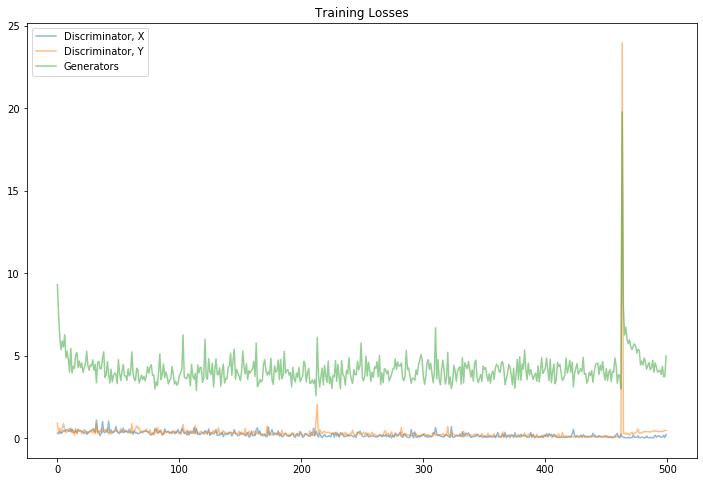

In [19]:
fig, ax = plt.subplots(figsize=(12,8))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator, X', alpha=0.5)
plt.plot(losses.T[1], label='Discriminator, Y', alpha=0.5)
plt.plot(losses.T[2], label='Generators', alpha=0.5)
plt.title("Training Losses")
plt.legend()

---
## Evaluate the Result!

As you trained this model, you may have chosen to sample and save the results of your generated images after a certain number of training iterations. This gives you a way to see whether or not your Generators are creating *good* fake images. For example, the image below depicts real images in the $Y$ set, and the corresponding generated images during different points in the training process. You can see that the generator starts out creating very noisy, fake images, but begins to converge to better representations as it trains (though, not perfect).

<img src='https://github.com/EliShayGH/deep-learning-v2-pytorch/blob/master/cycle-gan/notebook_images/sample-004000-summer2winter.png?raw=1' width=50% />

Below, you've been given a helper function for displaying generated samples based on the passed in training iteration.

In [0]:
import matplotlib.image as mpimg

# helper visualization code
def view_samples(iteration, sample_dir='samples_cyclegan'):
    
    # samples are named by iteration
    path_XtoY = os.path.join(sample_dir, 'sample-{:06d}-X-Y.png'.format(iteration))
    path_YtoX = os.path.join(sample_dir, 'sample-{:06d}-Y-X.png'.format(iteration))
    
    # read in those samples
    try: 
        x2y = mpimg.imread(path_XtoY)
        y2x = mpimg.imread(path_YtoX)
    except:
        print('Invalid number of iterations.')
    
    fig, (ax1, ax2) = plt.subplots(figsize=(18,20), nrows=2, ncols=1, sharey=True, sharex=True)
    ax1.imshow(x2y)
    ax1.set_title('X to Y')
    ax2.imshow(y2x)
    ax2.set_title('Y to X')


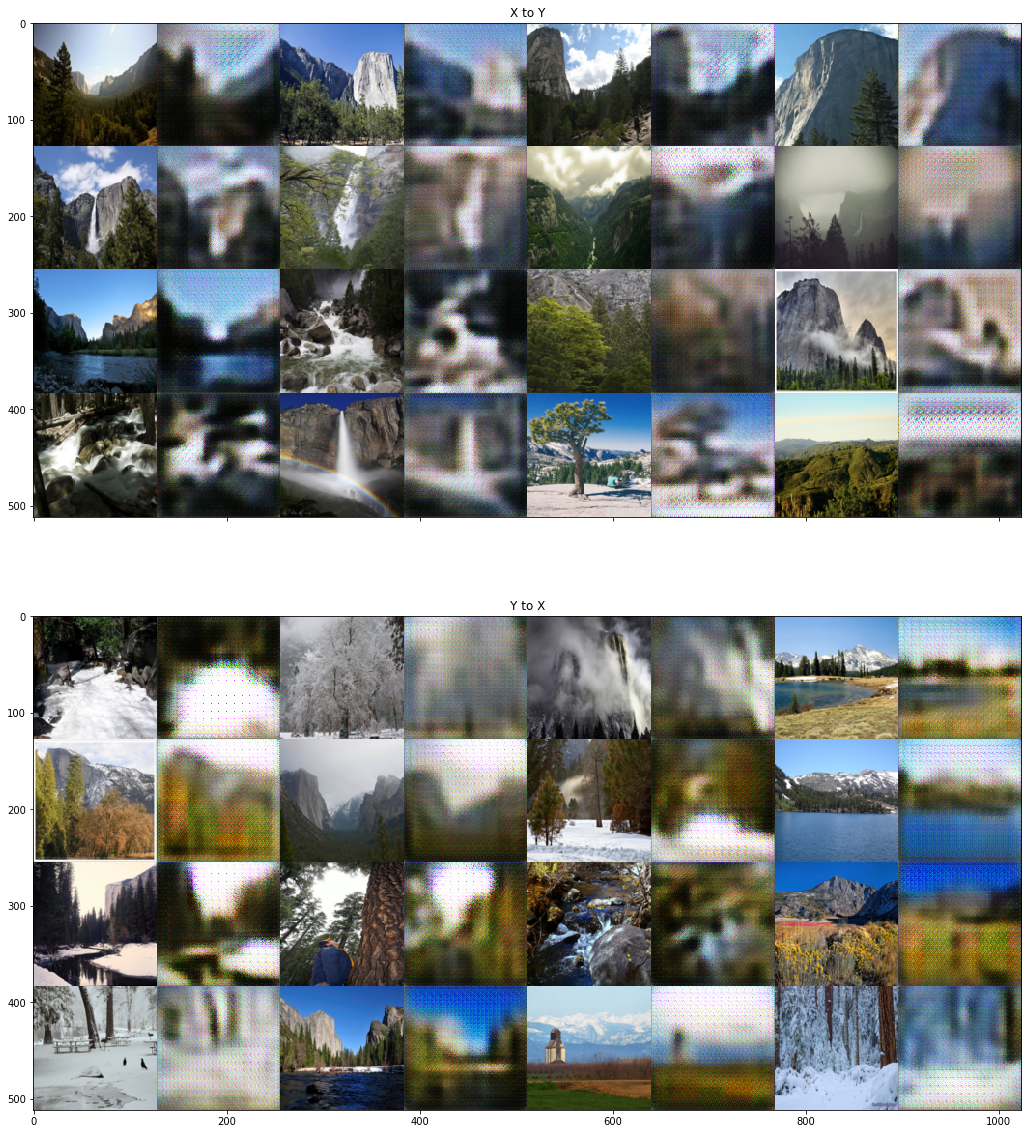

In [21]:
# view samples at iteration 100
view_samples(100, 'samples_cyclegan')

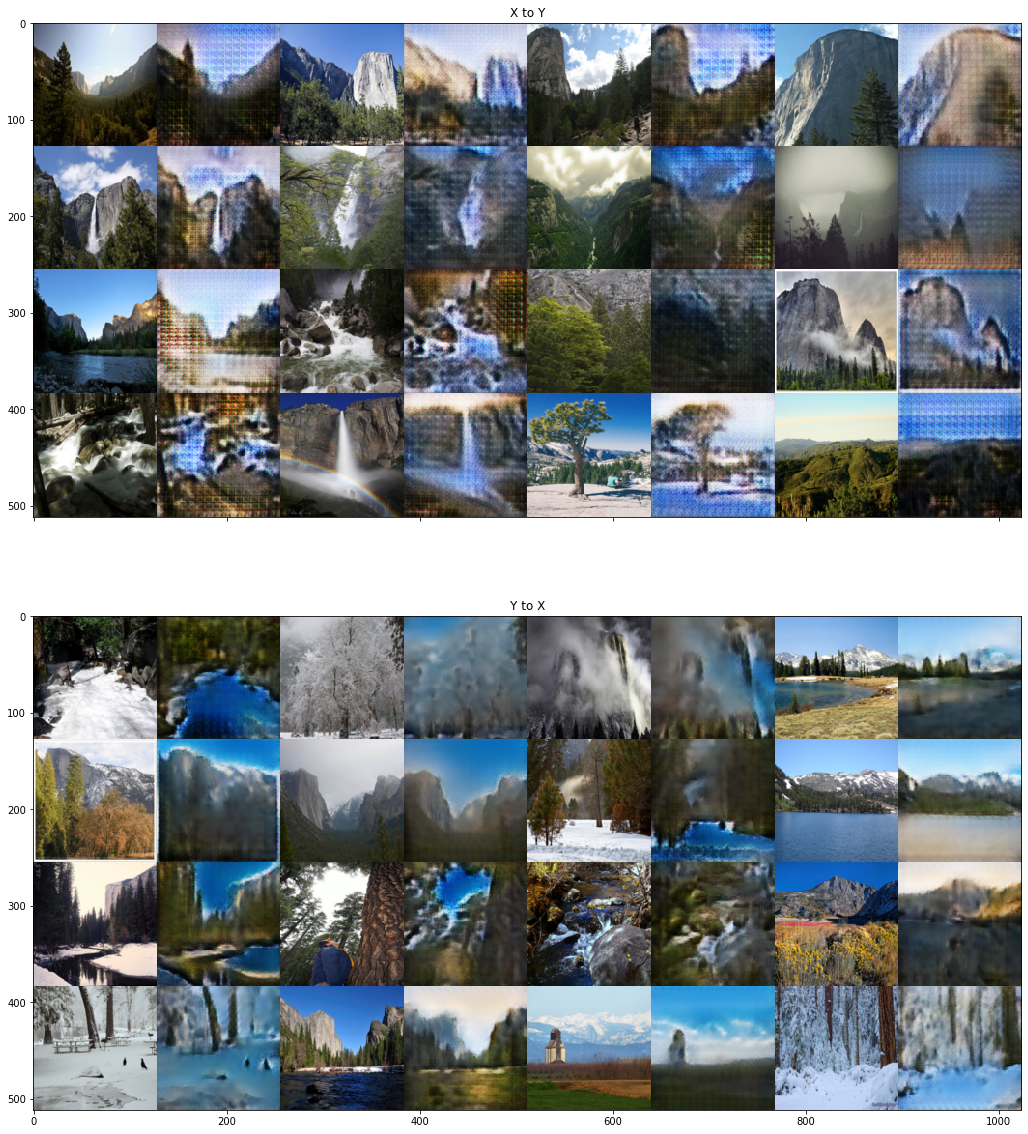

In [22]:
# view samples at iteration 1000
view_samples(5000, 'samples_cyclegan')

---
## Further Challenges and Directions

* One shortcoming of this model is that it produces fairly low-resolution images; this is an ongoing area of research; you can read about a higher-resolution formulation that uses a multi-scale generator model, in [this paper](https://arxiv.org/abs/1711.11585).
* Relatedly, we may want to process these as larger (say 256x256) images at first, to take advantage of high-res data.
* It may help your model to converge faster, if you initialize the weights in your network.
* This model struggles with matching colors exactly. This is because, if $G_{YtoX}$ and $G_{XtoY}$ may change the tint of an image; the cycle consistency loss may not be affected and can still be small. You could choose to introduce a new, color-based loss term that compares $G_{YtoX}(y)$ and $y$, and $G_{XtoY}(x)$ and $x$, but then this becomes a supervised learning approach. 
* This unsupervised approach also struggles with geometric changes, like changing the apparent size of individual object in an image, so it is best suited for stylistic transformations.
* For creating different kinds of models or trying out the Pix2Pix Architecture, [this Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/) which implements CycleGAN *and* Pix2Pix in PyTorch is a great resource.

**Once you are satified with your model, you are ancouraged to test it on a different dataset to see if it can find different types of mappings!**

---

### Different datasets for download

You can download a variety of datasets used in the Pix2Pix and CycleGAN papers, by following instructions in the [associated Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/README.md). You'll just need to make sure that the data directories are named and organized correctly to load in that data.